# RESTAURANT RATING 

### PROJECT

### Цель:
Повысить точность прогнозов модели при помощи более тщательной подготовки данных и генерации новых признаков.   
Предсказать рейтинг ресторана, используя модель RandomForestRegression, и посчитать метрики качества.

### Структура:  
1. Импорт и вспомогательные функции   
2. Первичный осмотр данных 
3. Очистка и подготовка данных  
4. Разведывательный анализ данных (EDA)  
   4.1 Распределение признаков  
   4.2 Корреляционный анализ данных
5. Генерация новых признаков
6. Формирование класса   
7. Обучение и валидация модели  
8. Submission  

# 1. Импорт и вспомогательные функции 

In [14]:
# Импортируем необходимые библиотеки и установим количество отображаемых строк и столбцов по умолчанию
import pandas as pd
import numpy as np
from collections import Counter
import re

import seaborn as sns  
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 3)

from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler 

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 100)       # показывать больше строк
pd.set_option('display.max_columns', 100)    # показывать больше колонок
pd.set_option('display.max_colwidth', None)  # показывать полный текст в ячейке

from tqdm import tqdm
tqdm.pandas()

import os
for dirname, _, filenames in os.walk('/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

### Вспомогательные функции

In [3]:
def get_df_info(df, name):
    # Вывод основной информации о датасете
    print(f'\nДатасет {name}:')
    display(df.head())
    print(f'Размер датасета: {df.shape}\n')
    display(df.info())
    print(f'Количество пропущенных значений в {name}: \n{df.isna().sum()[df.isna().sum() > 0]}')
    print(f'\nКоличество уникальных значений в {name}: \n{df.nunique()}')
    print(f'\nСтатистическая информация по {name}:')
    display(df.describe())
    display(df.describe(include = 'object'))
    print()
    print('         ***  ~~~~~~~~ *** ~~~~~~~~ *** ~~~~~~~~ *** ')
    print()

In [4]:
def rating_round(number):
    # Округление рейтинга с точностью до 0.5
    return np.round(number * 2) / 2

In [5]:
def get_isCapital(row):
    # Получение признака "isCapital" (1\0) - является ли город расположения ресторана столицей 
    if row['city'] in list_of_capitals:
        return 1
    else:
        return 0

In [6]:
def get_review_date_1(x):
    # Получение столбца "дата отзыва 1" - review_date_1
    rv_date_1 = pd.to_datetime(x[0]) if len(x) >= 1 else np.NaN
    return rv_date_1

def get_review_date_2(x):
    # Получение столбца "дата отзыва 2" - review_date_2
    rv_date_2 = pd.to_datetime(x[-1]) if len(x) >= 1 else np.NaN 
    return rv_date_2

In [7]:
def get_last_review_season(x):
    # Определение времени года
    if (pd.isna(x)):
        return 'other'
    if x.month in [12, 1, 2]:
        return 'winter'
    elif x.month in [3, 4, 5]:
        return 'spring'
    elif x.month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

In [8]:
# Списки с видами кухонь 
european_food = ['British', 'Cafe', 'Central European', 'Contemporary', 'Delicatessen', 'Eastern European',
                 'European', 'French', 'Fusion', 'Gastropub', 'International', 'Italian', 'Meat', 'Mediterranean', 
                 'North European', 'Pizza', 'Portuguese', 'Scandinavian',  'Soups', 'Spanish']
exotic_food = ['African', 'American', 'Asian', 'Caribbean', 'Caucasian', 'Indian',  'Japanese', 
               'Mexican', 'Middle Eastern',  'Oceania',  'Seafood',  'South American', 'Southwestern']

healthy_food = ['Gluten Free Options', 'Halal', 'Healthy', 'Kosher','Vegan Options', 'Vegetarian Friendly']

fastfood = ['Fast Food', 'Street Food']

drinks = ['Bar', 'Brew Pub','Pub', 'Wine Bar']

In [9]:
def create_word_list(line):
    # Получение списка отдельных слов в столбце "reviews_list"
    word_list_2 = []
    word_list_1 = str(line).split()
    for word in word_list_1:
        clean_word = ""
        for char in word:
            if char in '''!,.?'":;0123456789[]''':
                char = ""
            clean_word += char
        word_list_2.append(clean_word.lower())
    return word_list_2


def get_words_cnt(line):
    # Получение общего количества слов в отзыве
    word_list_2 =[]
    word_list_1 = str(line).split()
    for word in word_list_1:
        clean_word = ""
        for char in word:
            if char in '''!,.?'":;0123456789[]''':
                char = ""
            clean_word += char
        word_list_2.append(clean_word.lower())
    return len(word_list_2)

In [10]:
def get_positive_words_cnt(reviews):
    # Получение количества позитивно окрашенных слов в отзыве
    positive_words_count = 0
    txt = ' '.join(reviews)
    words = create_word_list(txt)
    words_count = len(words) if len(words) > 0 else 1
    #words_count = 1
    for word in words:
        if word in positive_words_list:
            #print(word)
            positive_words_count += 1  
    return positive_words_count


def get_positive_words_proportion(reviews):
    # Получение пропорции позитивно окрашенных слов от общего кол-ва слов в отзыве 
    positive_words_count = 0
    txt = ' '.join(reviews)
    words = create_word_list(txt)
    words_count = len(words) if len(words) > 0 else 1
    #words_count = 1
    for word in words:
        if word in positive_words_list:
            #print(word)
            positive_words_count += 1  
    return np.round(positive_words_count / words_count, 2)


def get_unique_pos_words_list(reviews): 
    # Получение списка уникальных позитивно окрашенных слов в отзыве
    txt = ' '.join(reviews)
    words = create_word_list(txt)
    positive_words = set(words).intersection(positive_words_list)
    if (len(positive_words) == 0):
        return np.NAN
    else:
        return list(positive_words)

In [11]:
def get_negative_words_cnt(reviews):
    # Получение количества негативно окрашенных слов в отзыве
    negative_words_count = 0
    txt = ' '.join(reviews)
    words = create_word_list(txt)
    words_count = len(words) if len(words) > 0 else 1
    #words_count = 1
    for word in words:
        if word in negative_words_list:
            #print(word)
            negative_words_count += 1  
    return negative_words_count


def get_negative_words_proportion(reviews):
    # Получение пропорции негативно окрашенных слов от общего кол-ва слов в отзыве 
    negative_words_count = 0
    txt = ' '.join(reviews)
    words = create_word_list(txt)
    words_count = len(words) if len(words) > 0 else 1
    #words_count = 1
    for word in words:
        if word in negative_words_list:
            #print(word)
            negative_words_count += 1  
    return np.round(negative_words_count / words_count, 2)


def get_unique_neg_words_list(reviews): 
    # Получение списка уникальных негативно окрашенных слов в отзыве
    txt = ' '.join(reviews)
    words = create_word_list(txt)
    negative_words = set(words).intersection(negative_words_list)
    if (len(negative_words) == 0):
        return np.NAN
    else:
        return list(negative_words)

# 2. Первичный осмотр данных

In [13]:
# ЗАГРУЗИМ ДАННЫЕ
train_df = pd.read_csv('main_task_restaurant.csv')
test_df = pd.read_csv('kaggle_task_restaurant.csv')
sample_submission = pd.read_csv('sample_submission_restaurant.csv')
                
city_df = pd.read_csv('worldcities.csv')
population_df = pd.read_excel('./PopulatinandArea.xlsx')

positive_words_df = pd.read_csv('positive-words.txt', comment = ';', header = None)
positive_words_list = positive_words_df[0].to_list()
negative_words_df = pd.read_csv('negative-words.txt', comment = ';', header = None)
negative_words_list = negative_words_df[0].to_list()

print(f'Список позитивно окрашенных слов: {positive_words_list[:6]} Количество слов: {len(positive_words_list)}\nСписок негативно окрашенных слов: {negative_words_list[:5]} Количество слов: {len(negative_words_list)}')
print(f'\nДатасет, содержащий различную информацию о городах:')
display(city_df.head(3))
print(f'\nДатасет, содержащий данные о населении европейских городов:')
display(population_df.head(3))

print(f'\nТренировочный датасет:')
display(train_df.head())
display(train_df.info())

print(f'\nsample_submission:')
display(sample_submission.head(3))

print(f'\nРазмер train_df: {train_df.shape}')
print(f'\nРазмер test_df: {test_df.shape}')
print(f'\nРазмер sample_submission: {sample_submission.shape}')

Список позитивно окрашенных слов: ['a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable'] Количество слов: 2006
Список негативно окрашенных слов: ['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable'] Количество слов: 4783

Датасет, содержащий различную информацию о городах:


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37732000.0,1392685764
1,Jakarta,Jakarta,-6.1750,106.8275,Indonesia,ID,IDN,Jakarta,primary,33756000.0,1360771077
2,Delhi,Delhi,28.6100,77.2300,India,IN,IND,Delhi,admin,32226000.0,1356872604



Датасет, содержащий данные о населении европейских городов:


,CityNo,City,Country,Population,Area in km2
0,1,Amsterdam,Netherland,851573,219.32
1,2,Athens,Greece,664046,2929.00
2,4,Barcelona,Spain,1620809,101.40



Тренировочный датасет:


,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]",/Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food'], ['07/06/2017', '06/19/2016']]",/Restaurant_Review-g189852-d7992032-Reviews-Buddha_Nepal-Stockholm.html,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'], ['01/08/2018', '01/06/2018']]",/Restaurant_Review-g186338-d8632781-Reviews-ROKA_Mayfair-London_England.html,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Esplanade-Berlin.html,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Friendly']",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice building but improvements need to be...'], ['11/18/2017', '02/19/2017']]",/Restaurant_Review-g187309-d6864963-Reviews-Augustiner_Schutzen_Garten-Munich_Upper_Bavaria_Bavaria.html,d6864963


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


None


sample_submission:


,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0



Размер train_df: (40000, 10)

Размер test_df: (10000, 9)

Размер sample_submission: (10000, 2)


**Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:**  
- **Restaurant_id** — идентификационный номер ресторана / сети ресторанов;
- **City** — город, в котором находится ресторан;
- **Cuisine Style** — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
- **Ranking** — место, которое занимает данный ресторан среди всех ресторанов своего города;
- **Rating** — рейтинг ресторана по данным TripAdvisor (именно это значение будет предсказывать модель);
- **Price Range** — диапазон цен в ресторане;
- **Number of Reviews** — количество отзывов о ресторане;
- **Reviews** — данные о двух отзывах, которые отображаются на сайте ресторана;
- **URL_TA** — URL страницы ресторана на TripAdvisor;
- **ID_TA** — идентификатор ресторана в базе данных TripAdvisor.

In [14]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет

train_df['sample'] = 1  # Помечаем трейн
test_df['sample'] = 0   # Помечаем тест
test_df['Rating'] = 0   # В тесте нет значения Rating, мы его должны предсказать, поэтому пока что заполняем нулями

data = test_df.append(train_df, sort = False).reset_index(drop = True) # Объединяем датасеты

# Преобразуем названия колонок для удобства 
data.columns = data.columns.str.lower().str.replace(' ', '_')
data.columns

Index(['restaurant_id', 'city', 'cuisine_style', 'ranking', 'price_range',
       'number_of_reviews', 'reviews', 'url_ta', 'id_ta', 'sample', 'rating'],
      dtype='object')

In [15]:
# Посмотрим детально на объединенный датасет
get_df_info(data, '"data"')


Датасет "data":


,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options']",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]",/Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/28/2017', '12/06/2017']]",/Restaurant_Review-g186525-d13129638-Reviews-Black_Ivy-Edinburgh_Scotland.html,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vegetarian Friendly', 'Gluten Free Options']",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic'], ['12/06/2017', '11/22/2017']]",/Restaurant_Review-g186338-d680417-Reviews-Quirinale-London_England.html,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seafood', 'Vegetarian Friendly', 'Gluten Free Options']",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good but pricey'], ['02/08/2018', '01/24/2018']]",/Restaurant_Review-g274924-d1112354-Reviews-Massimo_Ristorante-Bratislava_Bratislava_Region.html,d1112354,0,0.0


Размер датасета: (50000, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      50000 non-null  object 
 1   city               50000 non-null  object 
 2   cuisine_style      38410 non-null  object 
 3   ranking            50000 non-null  float64
 4   price_range        32639 non-null  object 
 5   number_of_reviews  46800 non-null  float64
 6   reviews            49998 non-null  object 
 7   url_ta             50000 non-null  object 
 8   id_ta              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


None

Количество пропущенных значений в "data": 
cuisine_style        11590
price_range          17361
number_of_reviews     3200
reviews                  2
dtype: int64

Количество уникальных значений в "data": 
restaurant_id        13094
city                    31
cuisine_style        10731
ranking              12975
price_range              3
number_of_reviews     1573
reviews              41857
url_ta               49963
id_ta                49963
sample                   2
rating                  10
dtype: int64

Статистическая информация по "data":


,ranking,number_of_reviews,sample,rating
count,50000.000000,46800.000000,50000.000000,50000.000000
mean,3664.427520,124.471197,0.800000,3.194430
std,3700.092452,294.114345,0.400004,1.705453
min,1.000000,2.000000,0.000000,0.000000
25%,972.000000,9.000000,1.000000,3.000000
50%,2278.000000,33.000000,1.000000,4.000000
75%,5241.000000,115.000000,1.000000,4.500000
max,16444.000000,9660.000000,1.000000,5.000000


,restaurant_id,city,cuisine_style,price_range,reviews,url_ta,id_ta
count,50000,50000,38410,32639,49998,50000,50000
unique,13094,31,10731,3,41857,49963,49963
top,id_227,London,['Italian'],$$ - $$$,"[[], []]",/Restaurant_Review-g187514-d2669414-Reviews-Vips-Madrid.html,d2669414
freq,19,7193,1332,23041,8112,2,2



         ***  ~~~~~~~~ *** ~~~~~~~~ *** ~~~~~~~~ *** 



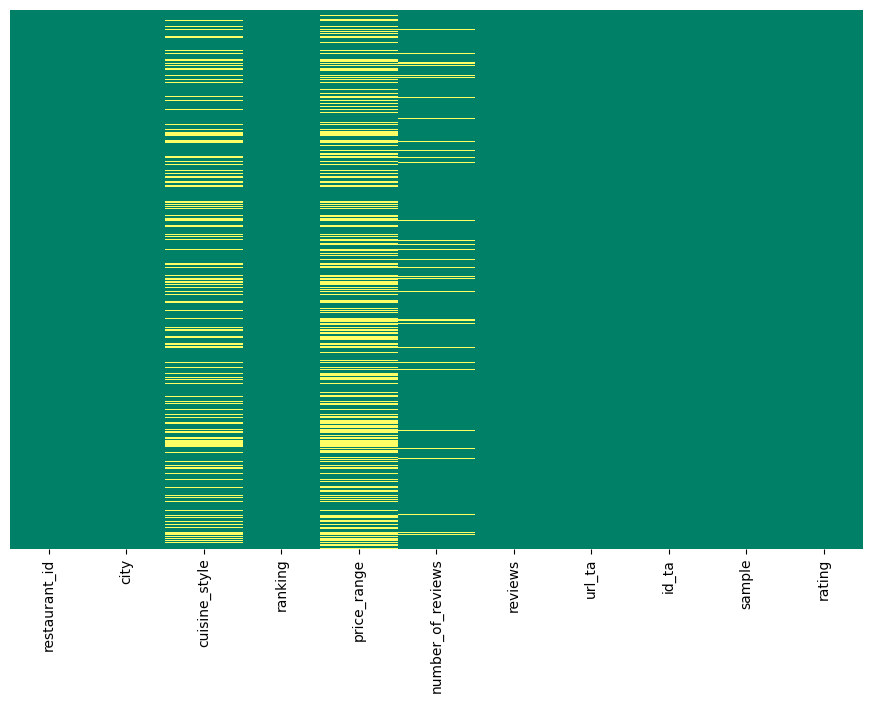

In [23]:
# Оценим визуально количество пропусков и их распределение
fig, ax = plt.subplots(figsize = (11, 7))   
sns_heatmap = sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap = 'summer')

In [84]:
data.sample(2)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating
44954,id_2979,Barcelona,"['Bar', 'Cafe', 'Mediterranean', 'Barbecue', 'Spanish', 'Contemporary']",2980.0,$$ - $$$,44.0,"[['Superb burgers.', 'One of the best burgers in Barcelona'], ['08/25/2016', '08/30/2015']]",/Restaurant_Review-g187497-d4674796-Reviews-La_Terrassa_de_l_Aiguajoc-Barcelona_Catalonia.html,d4674796,1,4.5
18087,id_1185,Oporto,"['International', 'European', 'Portuguese']",1186.0,$$ - $$$,21.0,"[[], []]",/Restaurant_Review-g189180-d11912411-Reviews-BbGourmet_Antas-Porto_Porto_District_Northern_Portugal.html,d11912411,1,3.5


In [85]:
data.reviews.iloc[7:10]

7                                                                                      [[], []]
8    [['Big group supper', 'Good food but very slow service :('], ['01/07/2018', '10/11/2017']]
9                                   [['Good food', 'Good pizza'], ['12/02/2017', '10/29/2017']]
Name: reviews, dtype: object

**Первичный осмотр датасета показал, что большинство признаков требует очистки и предварительной обработки:** 
- очистить данные от лишних символов (столбцы: cuisine_style, reviews)
- заполнить пропущенные значения (столбцы: cuisine_style, price_range и number_of_reviews)  
- преобразовать некоторые категориальные признаки, для этого в дальнейшем применим One-Hot Encoding

# 3. Очистка и подготовка данных

## Рассмотрим детальнее числовые столбцы

In [86]:
# Выведем названия всех числовых столбцов
for col in data.columns:
    if data[col].dtype != 'object':
        print(col)

ranking
number_of_reviews
sample
rating


### Столбец 'ranking'

Признак "ranking" - это  ранг, который занимает данный ресторан среди всех ресторанов своего города, т.е. показатель успешности ресторана среди всех ресторанов в городе. При исследовании этого признака необходимо учитывать общее количество ресторанов в данном городе.  

**Добавим новые признаки:**  
- **restaurants_in_city** - общее кол-во ресторанов в городе,  
- **rank_in_city** - отношение ранга каждого ресторана к общему количеству ресторанов в данном городе  
  (позиция ресторана среди всех ресторанов города).

Количество уникальных значений: 12975.


count    50000.000000
mean      3664.427520
std       3700.092452
min          1.000000
25%        972.000000
50%       2278.000000
75%       5241.000000
max      16444.000000
Name: ranking, dtype: float64

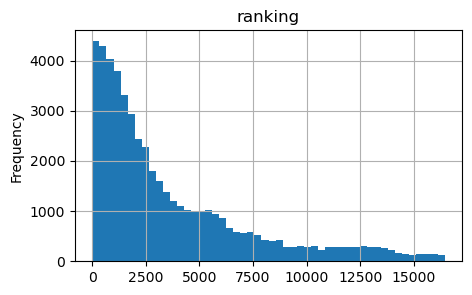

In [87]:
# Посмотрим значения описательных статистик и построим гистограмму распределения 
print(f'Количество уникальных значений: {data.ranking.nunique()}.')
data.ranking.plot(kind = 'hist', grid = True, title = 'ranking', bins = 50)
data.ranking.describe()  

In [88]:
# Добавим новые признаки "restaurants_in_city" и "rank_in_city"
restaurants_in_city = data['city'].value_counts().to_dict()
data['restaurants_in_city'] = data.city.map(restaurants_in_city)
data['rank_in_city'] = data.ranking / data.restaurants_in_city

### Столбец 'number_of_reviews' 

Аналогично признаку "ranking" при исследовании признака "number_of_reviews" необходимо учитывать город, где расположен конкретный ресторан, т.к. плотность населения, кол-во ресторанов и кол-во приезжающих туристов в разных городах будут отличаться.  

**Добавим признак "reviews_ratio" - отношение кол-ва отзывов отдельного ресторана к среднему количеству отзывов в данном городе.**  

Количество уникальных значений: 1573


count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: number_of_reviews, dtype: float64

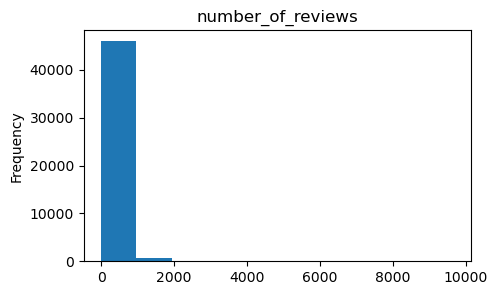

In [89]:
# Посмотрим значения описательных статистик и построим гистограмму распределения 
print(f'Количество уникальных значений: {data.number_of_reviews.nunique()}')
data.number_of_reviews.plot(kind = 'hist', title = 'number_of_reviews')
display(data.number_of_reviews.describe())

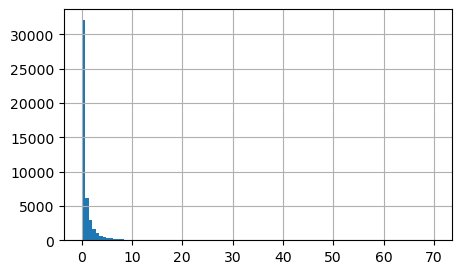

In [90]:
# Вынесем информацию о наличии пропуска в признаке "number_of_reviews" как отдельный признак
data['number_of_reviews_NaN'] = data.number_of_reviews.isna().astype('uint8')

# Добавим новый признак "reviews_ratio"
mean_reviews_per_city = data.groupby('city').number_of_reviews.mean()
data['reviews_ratio'] = data.number_of_reviews / data.city.apply(lambda x: mean_reviews_per_city[x])
data['reviews_ratio'].hist(bins = 100)
data.reviews_ratio.fillna(data.reviews_ratio.mean(), inplace = True)

### Столбец 'rating'  - целевая переменная

Количество уникальных значений: 10
Уникальные значения: [0.0, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]..


count    50000.000000
mean         3.194430
std          1.705453
min          0.000000
25%          3.000000
50%          4.000000
75%          4.500000
max          5.000000
Name: rating, dtype: float64

<AxesSubplot:xlabel='rating'>

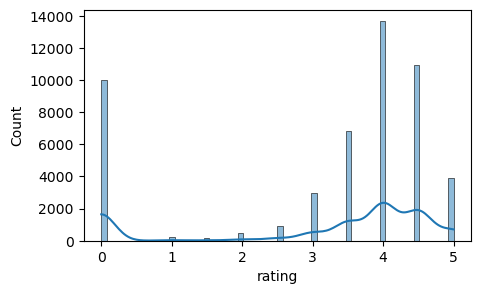

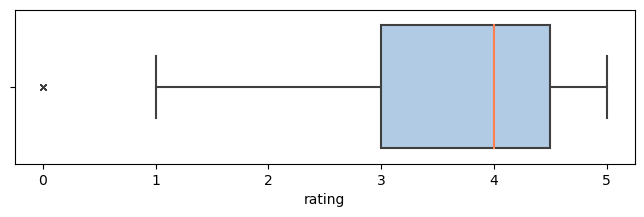

In [91]:
# Посмотрим значения описательных статистик и построим гистограмму распределения 
print(f'Количество уникальных значений: {data.rating.nunique()}\nУникальные значения: {sorted(data.rating.unique())}..')
sns.histplot(x = data.rating, kde = True)
display(data.rating.describe())

# Построим boxplot
fig = plt.figure(figsize = (8, 2))  
sns.boxplot(data = data, x = 'rating', flierprops = {"marker": "x"},
            medianprops = {"color": "coral"}, boxprops = {"facecolor": (.4, .6, .8, .5)})

## Рассмотрим категориальные столбцы

In [92]:
# Выведем названия всех категориальных столбцов
for col in data.columns:
    if data[col].dtype == 'object':
        print(col)

restaurant_id
city
cuisine_style
price_range
reviews
url_ta
id_ta


**Столбец "url_ta"** - URL страница ресторана на TripAdvisor, можно использовать в дальнейшем для парсинга данных. 

### Столбцы 'restaurant_id' и 'id_ta'

,restaurant_id,id_ta
38576,id_2058,d2427315
20597,id_1508,d1053283


Количество уникальных значений: 
"restaurant_id": 13094
"id_ta": 49963


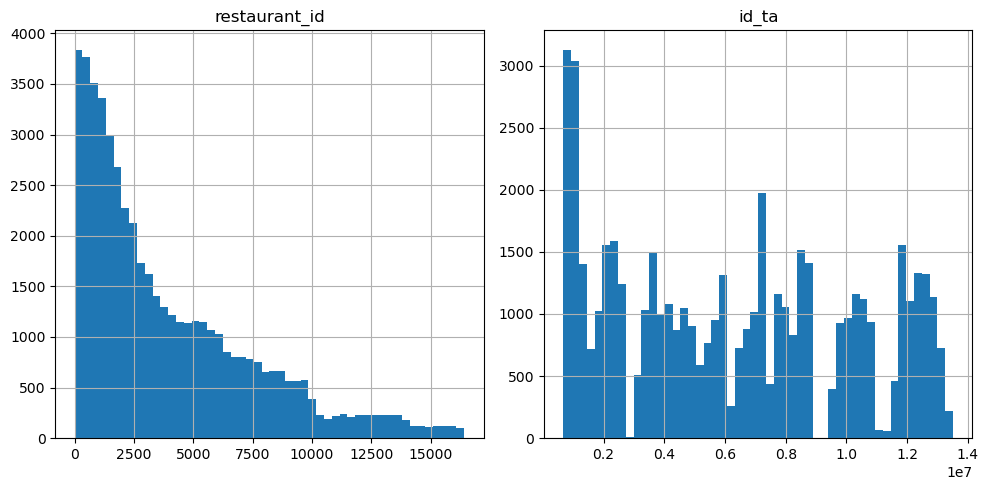

In [93]:
# Рассмотрим детальнее столбцы 'restaurant_id' и 'id_ta'
display(data[['restaurant_id', 'id_ta']].sample(2))
print(f'Количество уникальных значений: \n"restaurant_id": {data.restaurant_id.nunique()}\n"id_ta": {data.id_ta.nunique()}')

# Построим гистограммы распределения этих признаков
id_df = pd.concat([data.restaurant_id.apply(lambda x: x.split('_')[1]).astype('int'), 
                   data.id_ta.apply(lambda x: x.replace('d', '')).astype('int')], axis = 1)
id_df.hist(figsize = (10, 5), bins = 50)
plt.tight_layout()

Распределение признаков "Restaurant_id" и "id_ta" различаются.  
Распределение "Restaurant_id" очень похоже на распределение "Ranking".

<AxesSubplot:ylabel='Density'>

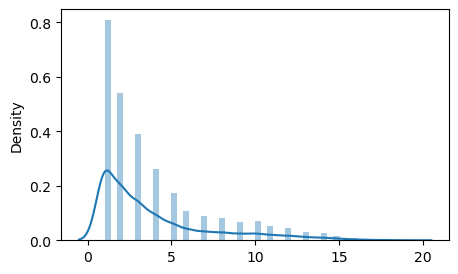

In [94]:
# Преобразуем столбец "id_ta"
data.id_ta = data.id_ta.apply(lambda x: x[1:]).astype('int')

# Id ресторанов повторяются - скорее всего это сети ресторанов 
# Добавим признак - "Количество ресторанов в сети" 
id_dict = data['restaurant_id'].value_counts().to_dict()
data['restaurants_in_chain'] = data['restaurant_id'].apply(lambda s: id_dict[s])

# Посмотрим распределение количества идентичных id-номеров у ресторанов, т.е. распределение кол-ва ресторанов в группах
sns.distplot(pd.Series(id_dict.values()))

### Столбец 'city' 

Уникальных значений: 31
Пропущенных значений: 0


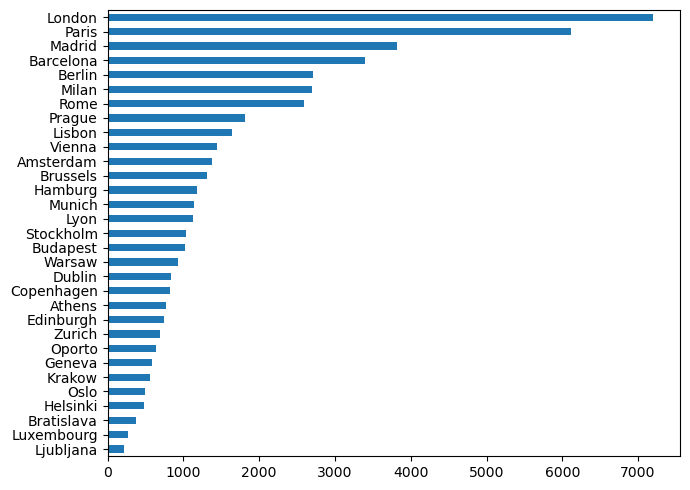

In [95]:
# Рассмотрим детальнее столбец city
print('Уникальных значений:', data.city.nunique())
print('Пропущенных значений:', data.city.isna().sum())
data.city.value_counts(ascending = True).plot(kind = 'barh', figsize = (7, 5))
plt.tight_layout()

### Столбец 'price_range' 

In [96]:
# Рассмотрим детальнее столбец price_range
print('Уникальных значений:', data.price_range.nunique())
print(f'Пропущенных значений: {data.price_range.isna().sum()}')
data.price_range.value_counts(dropna = False)

Уникальных значений: 3
Пропущенных значений: 17361


$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: price_range, dtype: int64

In [97]:
# Вынесем информацию о наличии пропусков в "price_range" как отдельный признак
data['price_range_NaN'] = data['price_range'].isna().astype('uint8')

# Перекодируем признак price_range, заменим пропуски наиболее часто встречающимся значением: "$$ - $$$"
price_dict = {'$' : 1, '$$ - $$$' : 2, '$$$$' : 3, np.NaN : 2}
data.price_range = data.price_range.replace(to_replace = price_dict).apply(lambda x: int(x))
data.price_range.value_counts()

2    40402
1     7816
3     1782
Name: price_range, dtype: int64

### Столбец 'cuisine_style' 

In [98]:
# Рассмотрим детальнее столбец 'cuisine_style'
display(data[['cuisine_style']].head())
print('Уникальных значений:', data.cuisine_style.nunique())
print(f'Пропущенных значений: {data.cuisine_style.isna().sum()}')

,cuisine_style
0,"['Bar', 'Pub']"
1,"['European', 'Scandinavian', 'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options']"
2,['Vegetarian Friendly']
3,"['Italian', 'Mediterranean', 'European', 'Vegetarian Friendly', 'Gluten Free Options']"
4,"['Italian', 'Mediterranean', 'European', 'Seafood', 'Vegetarian Friendly', 'Gluten Free Options']"


Уникальных значений: 10731
Пропущенных значений: 11590


Среднее количество кухонь в ресторанах: 3.12,
Медианное количество кухонь в ресторанах: 3.0.


<AxesSubplot:title={'center':'Распределение количества видов кухни в ресторанах'}>

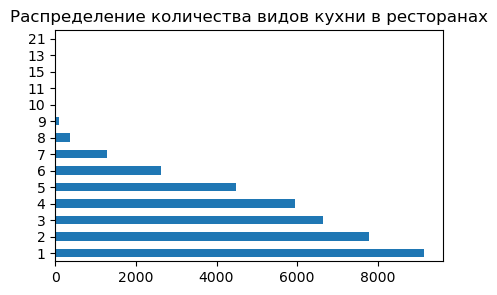

In [99]:
# Вынесем информацию о наличии пропусков в признаке "cuisine_style" как отдельный признак
data['cuisine_style_NaN'] = data.cuisine_style.isna().astype('uint8')

# Очистим признак "cuisine_style" от лишних элементов 
data.cuisine_style = data.cuisine_style.apply(lambda x: str(x).replace('[', '').replace(']', '').replace("'", '').split(', '))

# Посмотрим среднее и медианное количество кухонь в ресторанах 
mean_num_cuisine_style = round(data[data.cuisine_style_NaN == 0].cuisine_style.apply(len).mean(),2)
median_num_cuisine_style = data[data.cuisine_style_NaN == 0].cuisine_style.apply(len).median()
print(f'Среднее количество кухонь в ресторанах: {mean_num_cuisine_style},\nМедианное количество кухонь в ресторанах: {median_num_cuisine_style}.')
data[data.cuisine_style_NaN == 0].cuisine_style.str.len().value_counts()  \
            .plot(kind = 'barh', title = 'Распределение количества видов кухни в ресторанах')

In [100]:
# Добавим новый признак "cuisine_style_сnt" - количество видов кухонь в ресторане
# Заполним пропуски в "cuisine_style_сnt" медианой (среднее и медианное значение признака довольно близки)
data['cuisine_style_сnt'] = data.cuisine_style.apply(lambda x: len(x) if x != ['nan'] else median_num_cuisine_style)
display(data['cuisine_style_сnt'].value_counts()) 

# Посмотрим сколько всего типов кухни
cuisine_style_set = set(np.concatenate(data['cuisine_style']))
print(f'Всего видов кухни в датасете: {len(cuisine_style_set)}')

# Создадим объект Counter, где ключом будет тип кухни, а значением - кол-во реторанов, в которых представлен этот тип кухни
cuisine_style_counter = Counter()
for row in data['cuisine_style']:
    for cuisine in row:
        cuisine_style_counter[cuisine] += 1

most_pop_cuisine, second_most_pop_cuisine = cuisine_style_counter.most_common()[0][0], cuisine_style_counter.most_common()[1][0]
print(f'Наиболее часто встречающийся вид кухни: {most_pop_cuisine}')   # ---> Vegetarian Friendly

# Заменим пропуски в столбце "cuisine_style" значением самого популярного типа кухонь (Vegetarian Friendly)
data.cuisine_style = data.cuisine_style.apply(lambda x: ([most_pop_cuisine]) if x == ['nan'] else x)

# Посмотрим распределние типов кухни по их наличию в ресторанах
# pd.Series(dict(cuisine_style_counter.most_common()).values()).hist(bins = 20)

3.0     18228
1.0      9154
2.0      7794
4.0      5948
5.0      4482
6.0      2611
7.0      1294
8.0       363
9.0        93
10.0       26
11.0        4
15.0        1
13.0        1
21.0        1
Name: cuisine_style_сnt, dtype: int64

Всего видов кухни в датасете: 126
Наиболее часто встречающийся вид кухни: Vegetarian Friendly


### Столбец 'reviews' 

In [101]:
# Рассмотрим детальнее столбец 'reviews'
display(data[['reviews']].head())
print('Количество уникальных значений:', data.reviews.nunique())
print(f'Количество пропущенных NaN-значений: {data.reviews.isna().sum()}')
print(f'Количество фактических пропущенных значений "[[], []]": {data.reviews[data.reviews == "[[], []]"].count()}')

# Заполним два пропуска в столбце и вынесем информацию о наличии пропусков как отдельный признак
data['reviews'].fillna('[[], []]', inplace = True)
data['reviews_NaN'] = (data.reviews == '[[], []]').astype('int')    # data.reviews.apply(lambda x: x == '[[], []]')
data['reviews_NaN'].value_counts()

,reviews
0,"[[], []]"
1,"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"
2,"[['Better than the Links', 'Ivy Black'], ['12/28/2017', '12/06/2017']]"
3,"[['Most exquisite', 'Delicious and authentic'], ['12/06/2017', '11/22/2017']]"
4,"[['Always the best in bratislava', 'Very good but pricey'], ['02/08/2018', '01/24/2018']]"


Количество уникальных значений: 41857
Количество пропущенных NaN-значений: 2
Количество фактических пропущенных значений "[[], []]": 8112


0    41886
1     8114
Name: reviews_NaN, dtype: int64

In [102]:
# Добавим столбец "Средниее по городу количество отзывов"
mean_reviews_per_city_df = data.groupby('city', as_index = False).agg(mean_reviews_per_city = ('number_of_reviews', 'mean'))
data = data.merge(mean_reviews_per_city_df, on = 'city', how = 'left')

# Заполним пропуски в столбце "количество отзывов" (number_of_reviews): 
# для тех ресторанов, у которых нет отзывов в базе данных, ставим "0"   
# оставшиеся пропуски заполним средним количеством отзывов по городу
indexes = data[(data.reviews_NaN == 1) & (data.number_of_reviews_NaN == 1)].number_of_reviews.index.to_list()
data.number_of_reviews.iloc[indexes] = data.number_of_reviews.iloc[indexes].fillna(0)
data['number_of_reviews'].fillna(data['mean_reviews_per_city'], inplace = True)

print(f'Количество пропусков в датасете после первичной обработки: {data.isna().sum().sum()}')

Количество пропусков в датасете после первичной обработки: 0


Столбец **"reviews"** содержит два отзыва о ресторане и даты, когда эти отзывы были опубликованы. В столбце 6471 пропусков вида:  '[[], []]'.   
Из этого столбца будет полезно выделить следующую информацию: количество дней, прошедших с момента последнего review, количество дней между двумя последними отзывами (относительная частота отзывов), общее кол-во отзывов у ресторана, кол-во позитивно \ негативно окрашенных слов в отзывах и др. 

**На данном этапе проведен первичный анализ и очистка данных: удалены лишние элементы и заполнены пропущенные значения.  
В процессе анализа и подготовки данных созданы следующие признаки:**  
- **restaurants_in_city** -  количество ресторанов в городе,  
- **rank_in_city** - отношение ранга каждого ресторана к общему количеству ресторанов в данном городе,   
- **reviews_ratio** - отношение кол-ва отзывов каждого отдельного ресторана к общему количеству отзывов в данном городе,  
- **restaurants_in_chain** - количество ресторанов в сети,
- **cuisine_style_сnt** - количество типов кухни в ресторане,  
- **mean_reviews_per_city** - средниее по городу количество отзывов,
- а также столбцы: **number_of_reviews_NaN, price_range_NaN, cuisine_style_NaN** и **reviews_NaN,** содержащие информацию о пропущенных значениях в соответствующих столбцах.

# 4. Разведывательный анализ данных (EDA)

## 4.1 Распределение признаков

<AxesSubplot:>

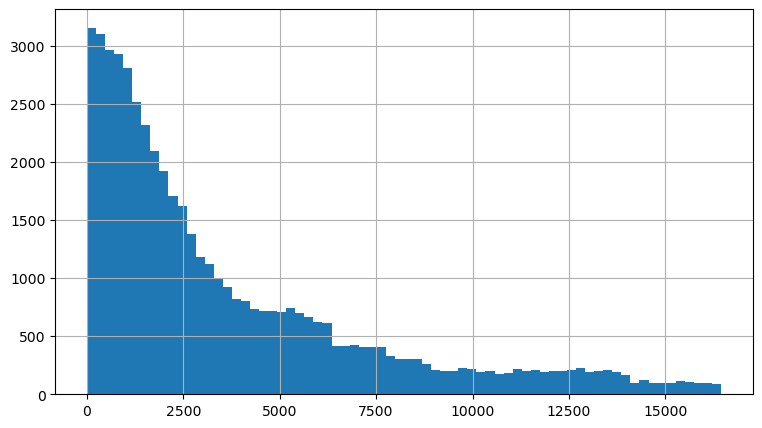

In [103]:
# Установим размер графика по умолчанию
plt.rcParams['figure.figsize'] = (9, 5)

# Посмотрим распределение признака "ranking"
data['ranking'].hist(bins = 70)

График показывает, что довольно много ресторанов не дотягивают и до 2500 места в своем городе.

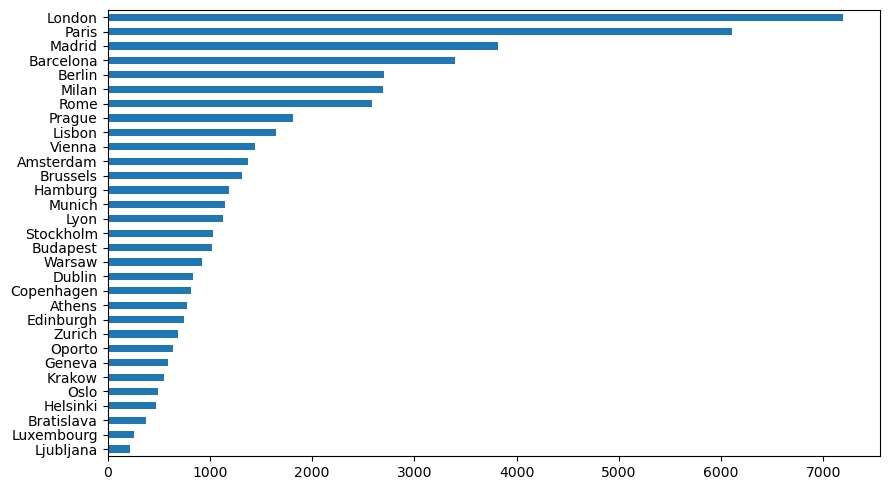

In [104]:
# Посмотрим рапределение ресторанов по городам
data.city.value_counts(ascending = True).plot(kind = 'barh')
plt.tight_layout()

<AxesSubplot:>

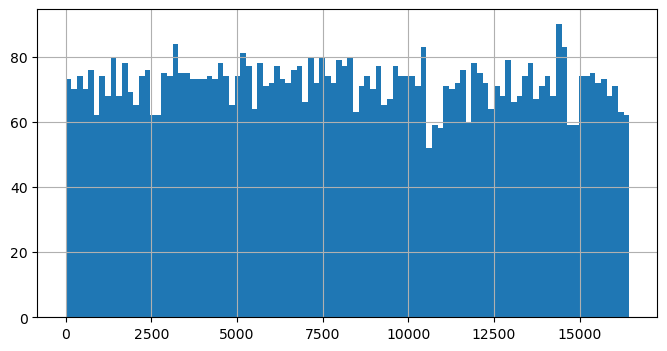

In [105]:
# Посмотрим, как изменится распределение в большом городе
plt.rcParams['figure.figsize'] = (8, 4)
data[data.city == 'London'].ranking.hist(bins = 100)

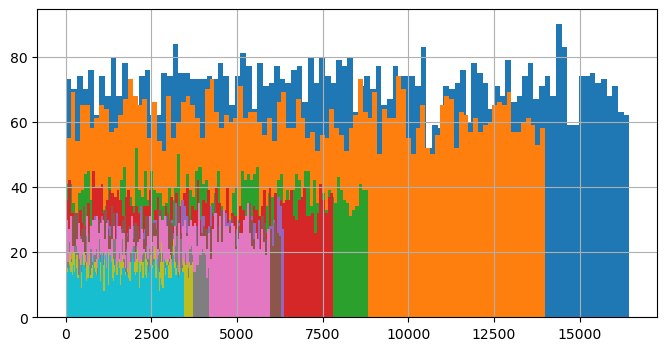

In [106]:
# Посмотрим на топ-10 городов
for city in data.city.value_counts()[:10].index:
    data[data.city == city].ranking.hist(bins = 100)

Признак "Ranking" имеет вполне нормальное распределение, но т.к. в крупных городах расположено больше ресторанов, можно наблюдать смещение на графике. Чтобы устранить смещение нормализуем признак, то есть проведём min-max нормализацию (Min-Max Scaling)

<AxesSubplot:>

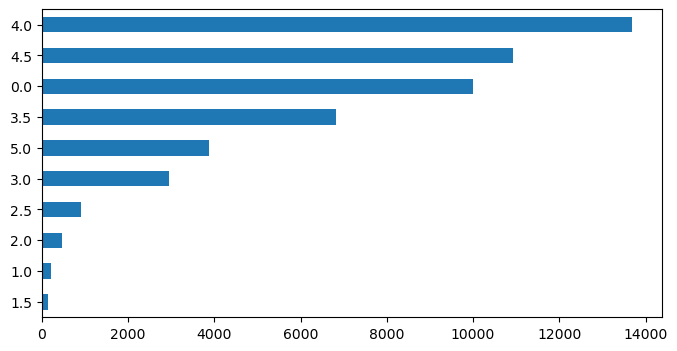

In [107]:
# Посмотрим распределение целевой переменной
data['rating'].value_counts(ascending = True).plot(kind = 'barh')

<AxesSubplot:>

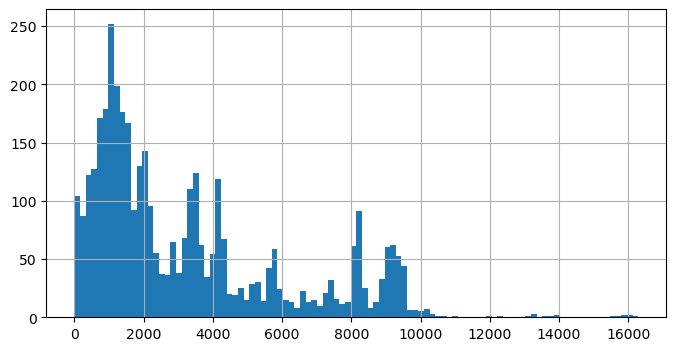

In [108]:
# Посмотрим распределение целевой переменной относительно признака ranking 
data[data['rating'] == 5].ranking.hist(bins = 100)

<AxesSubplot:>

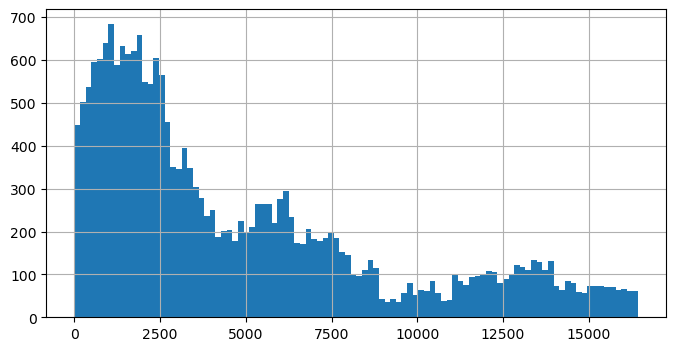

In [109]:
data[data['rating'] < 4].ranking.hist(bins = 100)

Судя по графикам, рестораны с меньшим рейтингом имеют более низкое место в рейтинге по городу.

Vegetarian Friendly    14021
European               12561
nan                    11590
Mediterranean           7820
Italian                 7433
                       ...  
Fujian                     2
Salvadoran                 1
Xinjiang                   1
Burmese                    1
Latvian                    1
Length: 126, dtype: int64

<AxesSubplot:>

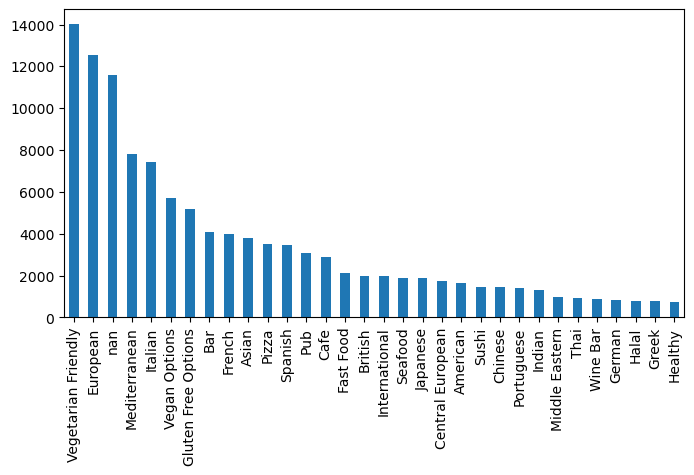

In [110]:
# Подавляющее кол-во ресторанов включают кухни: Vegetarian Friendly и European 
display(pd.Series(dict(cuisine_style_counter.most_common())))

# Популярность стилей кухонь (30% наиболее популярных)
threshold = int(np.percentile(list(dict(cuisine_style_counter.most_common()).values()), 30))  # np.quantile() 
pd.Series(dict(cuisine_style_counter.most_common()[:threshold])).plot(kind = 'bar')

<AxesSubplot:>

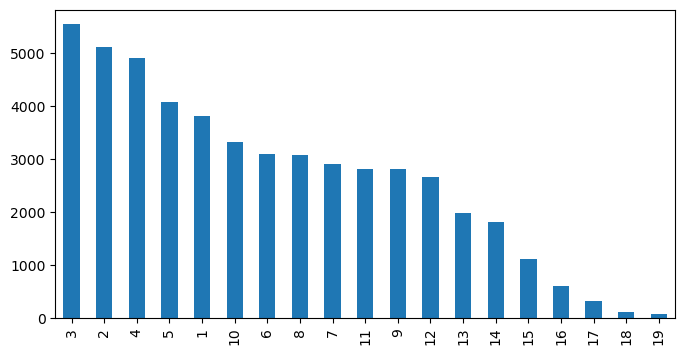

In [111]:
# Распределение количества ресторанов в сети 
data.restaurants_in_chain.value_counts().plot(kind = 'bar')

## 4.2 Корреляционный анализ данных

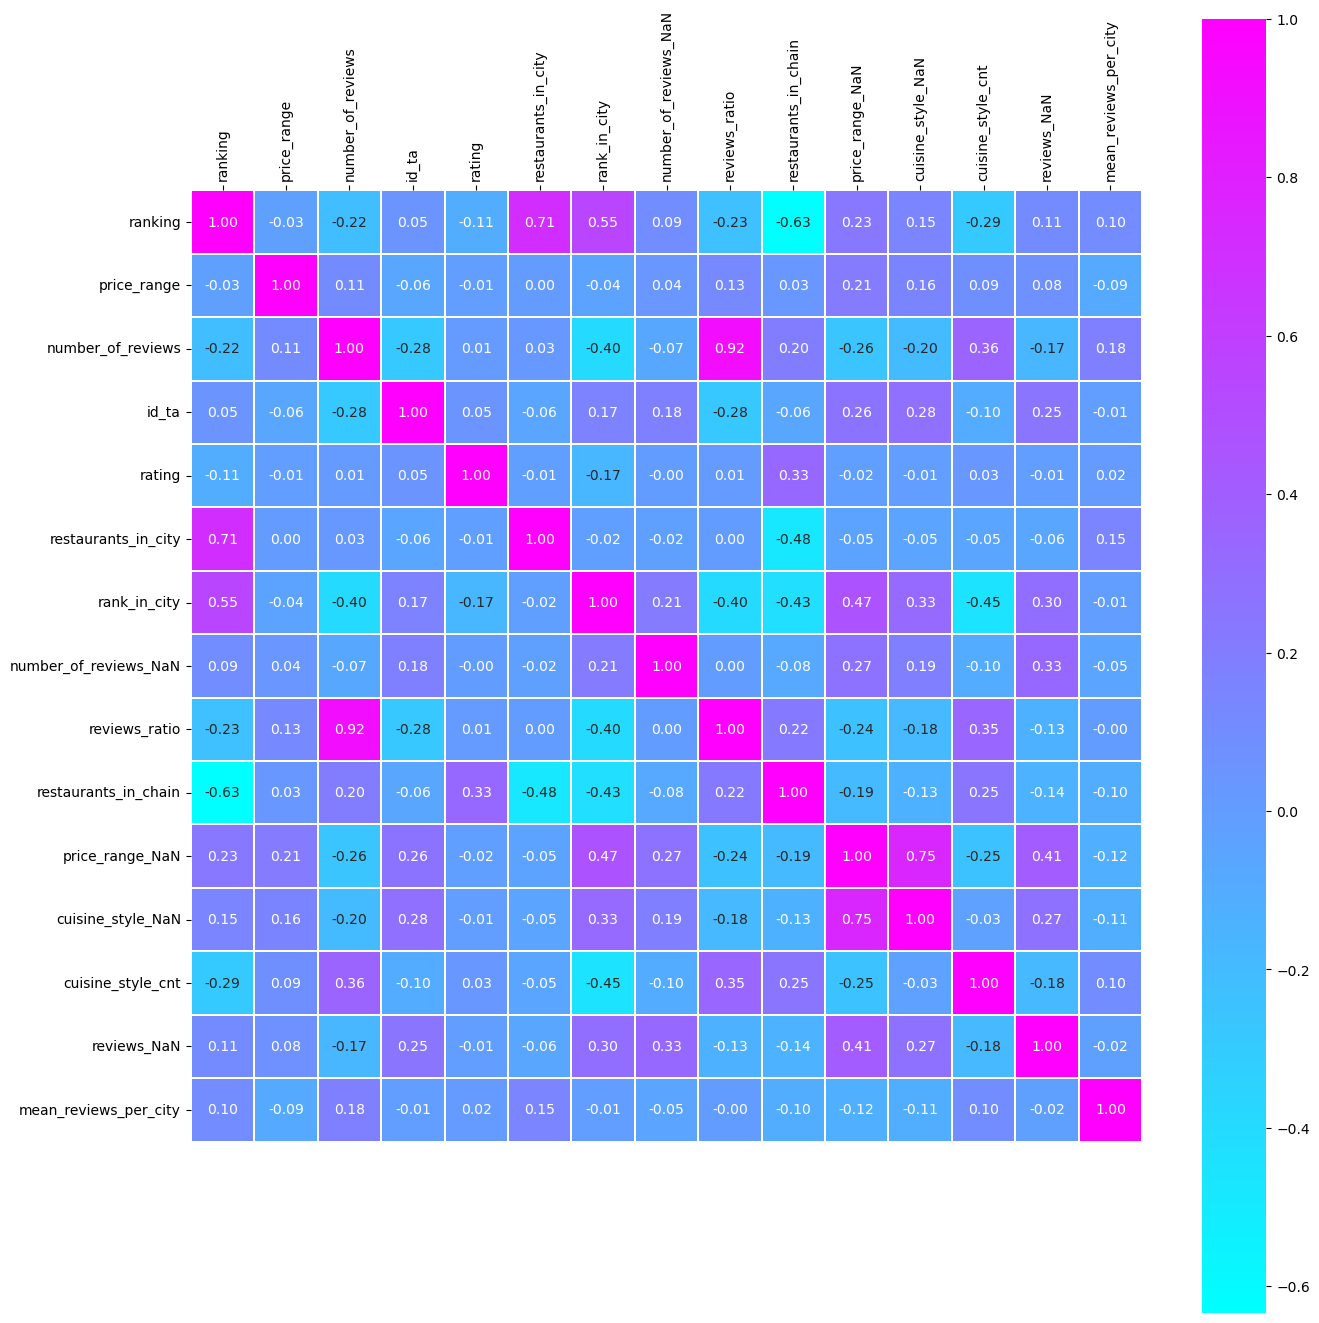

In [112]:
plt.rcParams['figure.figsize'] = (14, 14)
ax = sns.heatmap(data.drop('sample', axis = 1).corr(), square = True, annot = True, fmt = ".2f", linewidths = 0.1, cmap="cool")
ax.xaxis.set_ticks_position('top')

ax.xaxis.set_tick_params(rotation = 90)
plt.tight_layout()

In [113]:
data.corr().applymap(lambda x: x if x > 0.5 else '')

,ranking,price_range,number_of_reviews,id_ta,sample,rating,restaurants_in_city,rank_in_city,number_of_reviews_NaN,reviews_ratio,restaurants_in_chain,price_range_NaN,cuisine_style_NaN,cuisine_style_сnt,reviews_NaN,mean_reviews_per_city
ranking,1.0,,,,,,0.709012,0.55495,,,,,,,,
price_range,,1.0,,,,,,,,,,,,,,
number_of_reviews,,,1.0,,,,,,,0.916304,,,,,,
id_ta,,,,1.0,,,,,,,,,,,,
sample,,,,,1.0,0.936543,,,,,,,,,,
rating,,,,,0.936543,1.0,,,,,,,,,,
restaurants_in_city,0.709012,,,,,,1.0,,,,,,,,,
rank_in_city,0.55495,,,,,,,1.0,,,,,,,,
number_of_reviews_NaN,,,,,,,,,1.0,,,,,,,
reviews_ratio,,,0.916304,,,,,,,1.0,,,,,,


In [114]:
# Посмотрим какие признаки больше всего влияют на 'rating'
corr = round(data.corr(), 2)
corr['rating'].abs().sort_values(ascending = False)[:15]

rating                   1.00
sample                   0.94
restaurants_in_chain     0.33
rank_in_city             0.17
ranking                  0.11
id_ta                    0.05
cuisine_style_сnt        0.03
price_range_NaN          0.02
mean_reviews_per_city    0.02
price_range              0.01
number_of_reviews        0.01
restaurants_in_city      0.01
reviews_ratio            0.01
cuisine_style_NaN        0.01
reviews_NaN              0.01
Name: rating, dtype: float64

Корреляция между целевой переменной и остальными признаками довольно слабая (нет выраженной зависимости).

# 5. Генерация новых признаков

In [115]:
display(data.head(2))
print(f'Признаки в датасете на данный момент: \n{data.columns.to_list()}')
print(f'\nРазмер датасета: {data.shape}') # (50000, 21)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,restaurants_in_city,rank_in_city,number_of_reviews_NaN,reviews_ratio,restaurants_in_chain,price_range_NaN,cuisine_style_NaN,cuisine_style_сnt,reviews_NaN,mean_reviews_per_city
0,id_0,Paris,"[Bar, Pub]",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html,10746918,0,0.0,6108,2.122299,0,0.034176,16,0,0,2.0,1,117.040915
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, Vegetarian Friendly, Vegan Options]",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]",/Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html,6674944,0,0.0,475,0.223158,0,1.469249,10,0,0,5.0,0,66.020134


Признаки в датасете на данный момент: 
['restaurant_id', 'city', 'cuisine_style', 'ranking', 'price_range', 'number_of_reviews', 'reviews', 'url_ta', 'id_ta', 'sample', 'rating', 'restaurants_in_city', 'rank_in_city', 'number_of_reviews_NaN', 'reviews_ratio', 'restaurants_in_chain', 'price_range_NaN', 'cuisine_style_NaN', 'cuisine_style_сnt', 'reviews_NaN', 'mean_reviews_per_city']

Размер датасета: (50000, 21)


In [116]:
# Добавим признак "Явлется ли ресторан сетевым"  (1\0)
data['restaurant_net_id'] = data.restaurant_id.apply(lambda x: x.split('_')[1])
is_network_restaurant = (data['restaurant_net_id'].value_counts() > 2).astype('int')
data['is_network_restaurant']  = data['restaurant_net_id'].map(is_network_restaurant) 

In [117]:
# Наличие в ресторане самой популярной кухни (1/0)
data['has_MostPop_cusine'] = data.cuisine_style.apply(lambda x: 1 if most_pop_cuisine in x else 0)

# Наличие в ресторане 30% наиболее популярных видов кухни (1/0)
threshold = int(np.percentile(list(dict(cuisine_style_counter.most_common()).values()), 30))   # np.quantile()
top_30_percent_cuisines_list = list(dict(cuisine_style_counter.most_common()).keys())[:threshold]
data['has_top30_percent_cuisines'] = data['cuisine_style']  \
            .apply(lambda x: max([1 if i in top_30_percent_cuisines_list else 0 for i in x]))

# Cписок кухонь, входящих в 30% наиболее популярных, для остальных - "Other"
data['top_30_percent_cuisine'] = data['cuisine_style']  \
            .apply(lambda x: list(set(list(i if i in top_30_percent_cuisines_list else 'Other' for i in x))))

# Кол-во кухонь в ресторане больше или меньше среднего (1/0)
data['is_multy_cuisine'] = data.cuisine_style_сnt.apply(lambda x: 1 if  x >= round(mean_num_cuisine_style) else 0 )

# Количество видов кухонь в городе
cuisines_сnt_in_city_dict = dict(map(lambda x: (x[0], len(set(x[1]))), data.groupby('city').cuisine_style.sum().to_dict().items()))
data['cuisines_сnt_in_city'] = data['city'].map(cuisines_сnt_in_city_dict)

# Относительная доля кухонь в ресторане
data['weighed_cuisines_cnt'] = data['cuisine_style_сnt'] / data['cuisines_сnt_in_city']

# Местная, экзотическая, здоровая кухня, фаст-фуд и напитки
data['european_food'] = data['cuisine_style'].apply(lambda x: sorted(set(1 if i in european_food else 0 for i in x))[-1])
data['exotic_food'] = data['cuisine_style'].apply(lambda x: sorted(set(1 if i in exotic_food else 0 for i in x))[-1])
data['healthy_food'] = data['cuisine_style'].apply(lambda x: sorted(set(1 if i in healthy_food else 0 for i in x))[-1])
data['fastfood'] = data['cuisine_style'].apply(lambda x: sorted(set(1 if i in fastfood else 0 for i in x))[-1])
data['drinks'] = data['cuisine_style'].apply(lambda x: sorted(set(1 if i in drinks else 0 for i in x))[-1])

In [118]:
# Список с датами отзывов
data['review_dates'] = data['reviews'].apply(lambda x: re.findall(r'\d\d\/\d\d\/\d{4}', x))

# Даты последних отзывов в формате datetime
data['review_date_1'] = data['review_dates'].apply(lambda row: get_review_date_1(row))
data['review_date_2'] = data['review_dates'].apply(lambda row: get_review_date_2(row))

# Заполним пропуски, руководствуясь тем, что позиция ресторана положительно зависит от даты последнего отзыва
data['review_date_1'].fillna(datetime(2000,1,1,), inplace = True)
data['review_date_2'].fillna(datetime(1990,1,1,), inplace = True)

# Количество дней между двумя последними отзывами
data = data.assign(review_days_gap = lambda x: ((x['review_date_1'] - x['review_date_2']).dt.days))

# Количество дней, прошедших с публикации последнего отзыва
current_date = datetime.today()
data['days_since_last_review'] = (current_date - (data[['review_date_1','review_date_2']].max(axis = 1))).dt.days

# Время года, когда был оставлен последний отзыв
data['last_review_season'] = data[['review_date_1', 'review_date_2']].max(axis = 1).apply(get_last_review_season)

In [119]:
# Cписок из двух последних отзывов 
data['reviews_list'] = data['reviews'].apply(lambda x: re.split(r'\d\d\/\d\d\/\d{4}', x)).apply(lambda x: x[0]) \
                        .apply(lambda x: x.strip("[],' ")).apply(lambda x: x.split("', '"))

# Кол-во представленных в базе данных отзывов
data['review_сnt'] = data.reviews_list.apply(lambda x: len(x))

# Общая длина последних отзывов (побуквенно)
data['review_letter_length'] = data['reviews_list']  \
                        .apply(lambda x: len(x[0]) if len(x) == 1 else len(x[0]) + len(x[1]) if len(x) > 1 else np.NaN)

# Средняя длина последних отзывов (побуквенно)
data['mean_review_letter_length'] = data['reviews_list']  \
                        .apply(lambda x: len(x[0]) if len(x) == 1 else (len(x[0]) + len(x[-1])) / 2) 

# Общее количество слов в отзыве
data['review_words_cnt'] = data.reviews_list.apply(lambda x: get_words_cnt(x))

# Кол-во позитивно окрашенных слов в отзывах
data['positive_words_cnt'] = data.reviews_list.apply(lambda x: get_positive_words_cnt(x))

# Пропорция позитивно окрашенных слов от общего кол-ва слов в отзывах 
data['positive_words_proportion'] = data.reviews_list.apply(lambda x: get_positive_words_proportion(x))

# Список уникальных позитивно окрашенных слов в отзывах
data['unique_pos_words_list'] = data.reviews_list.apply(lambda x: get_unique_pos_words_list(x))

# Кол-во негативно окрашенных слов в отзывах
data['negative_words_cnt'] = data.reviews_list.apply(lambda x: get_negative_words_cnt(x))

# Пропорция негативно окрашенных слов от общего кол-ва слов в отзывах 
data['negative_words_proportion'] = data.reviews_list.apply(lambda x: get_negative_words_proportion(x))

# Список уникальных негативно окрашенных слов в отзывах
data['unique_neg_words_list'] = data.reviews_list.apply(lambda x: get_unique_neg_words_list(x))

# Заполняем пропуски в списках уникальных позитивных и негативных слов (unique_pos_words_list,  unique_neg_words_list) 
data['unique_pos_words_list'] = data['unique_pos_words_list'].fillna('positive_words_NAN')
data['unique_neg_words_list'] = data['unique_neg_words_list'].fillna('negative_words_NAN')

In [120]:
# Население городов 
# Для начала проведем небольшую проверку на наличие и идентичные названия городов в двух датасетах, 
# затем присоединим столбец "population"
data_city_list, pop_df_city_list = data.city.unique().tolist(), population_df.City.unique().tolist()
print(f'Совпадение уникальных городов в датасетах "data" и "population_df": {set(data_city_list) == set(pop_df_city_list)}')
population_df.columns = population_df.columns.str.lower()
data = data.merge(population_df[['city', 'population']], on = 'city', how = 'left')  \
        .rename(columns = {'population' : 'city_population'})

# Страна 
country_dict = population_df.groupby('city').country.sum().to_dict()
data['country'] = data.city.map(country_dict)

Совпадение уникальных городов в датасетах "data" и "population_df": True


In [121]:
# Cредний ренкинг (ranking) ресторанов по каждому городу
mean_ranking = data.groupby('city').ranking.mean()
data['mean_ranking_per_city'] = data.city.apply(lambda x: mean_ranking[x])

# Расстояние до среднего по городу ренкингу 
data['difference_with_mean_ranking'] = data.mean_ranking_per_city - data.ranking

# Зависимость взвешенного ренкинга ресторана от населения города
data['weighed_rank_by_population'] = data['rank_in_city']  / data['city_population'] 

# Кол-во ресторанов на 1000 человек населения
data['restaurants_per_1000_people']  = data['restaurants_in_city'] / (data['city_population'] * 1000)

# Как часто в городе оставляют отзывы
data['review_frequency'] = data['number_of_reviews'] / data['city_population']

# Ранг ресторана с учетом частоты отзывов в городе
data['rank_by_review_frq'] = data['rank_in_city']  *  data['review_frequency'] 

# Количество отзывов на тысячу ресторанов в городе
data['reviews_by_1000_restaurants'] = data['number_of_reviews'] / data['restaurants_in_city'] * 1000

In [123]:
# Ресторан расположен в столице или нет (1\0)
list_of_capitals = city_df[city_df.capital == 'primary'].city_ascii.unique().tolist()
data['isCapital'] = data.apply(lambda x: get_isCapital(x), axis = 1)

# Помечаем, входит ли город в top-10 городов, если ДА, то пишем его назавние, если НЕТ - "other_city"
top_cities = data['city'].value_counts()[0:10].index.to_list()
data['top_cities'] = data.city.apply(lambda x: x if x in top_cities else 'other_city')

In [124]:
# Средняя цена в городе
mean_price_range_perCity = data.groupby('city')['price_range'].mean().to_dict()
data['mean_price_in_city'] = data['city'].apply(lambda x: mean_price_range_perCity[x])

## Осмотр признаков

In [126]:
display(data.sample(2))
print(f'\nПризнаки в датасете на данный момент: \n{data.columns.to_list()}')
print(f'\nРазмер датасета: {data.shape}')  # (50000, 63)
print(f'Количество пропущенных значений: {data.isna().sum().sum()}')

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,restaurants_in_city,rank_in_city,number_of_reviews_NaN,reviews_ratio,restaurants_in_chain,price_range_NaN,cuisine_style_NaN,cuisine_style_сnt,reviews_NaN,mean_reviews_per_city,restaurant_net_id,is_network_restaurant,has_MostPop_cusine,has_top30_percent_cuisines,top_30_percent_cuisine,is_multy_cuisine,cuisines_сnt_in_city,weighed_cuisines_cnt,european_food,exotic_food,healthy_food,fastfood,drinks,review_dates,review_date_1,review_date_2,review_days_gap,days_since_last_review,last_review_season,reviews_list,review_сnt,review_letter_length,mean_review_letter_length,review_words_cnt,positive_words_cnt,positive_words_proportion,unique_pos_words_list,negative_words_cnt,negative_words_proportion,unique_neg_words_list,city_population,country,mean_ranking_per_city,difference_with_mean_ranking,weighed_rank_by_population,restaurants_per_1000_people,review_frequency,rank_by_review_frq,reviews_by_1000_restaurants,isCapital,top_cities,mean_price_in_city
20592,id_350,Geneva,"[Bar, European]",352.0,2,70.0,"[['Great!', 'Time for a drink'], ['07/29/2017', '06/29/2017']]",/Restaurant_Review-g188057-d6952841-Reviews-Barbershop_Geneve-Geneva.html,6952841,1,4.5,590,0.596610,0,1.125884,11,0,0,2.0,0,62.173358,350,1,0,1,"[European, Bar]",0,62,0.032258,1,0,0,0,1,"[07/29/2017, 06/29/2017]",2017-07-29,2017-06-29,30,2130,summer,"[Great!, Time for a drink]",2,22,11.0,5,1,0.2,[great],0,0.0,negative_words_NAN,198979,Switzerland,713.227119,361.227119,2.998357e-06,2.965137e-06,0.000352,0.00021,118.644068,0,other_city,2.033898
4812,id_4812,London,"[Fast Food, Asian, Thai, Vegetarian Friendly, Vegan Options, Halal]",1808.0,1,336.0,"[['Lovely Little Find', 'Lovely food'], ['12/31/2017', '12/29/2017']]",/Restaurant_Review-g186338-d811931-Reviews-Spicy_Basil-London_England.html,811931,0,0.0,7193,0.251355,0,2.435341,4,0,0,6.0,0,137.968381,4812,1,1,1,"[Fast Food, Vegan Options, Thai, Halal, Vegetarian Friendly, Asian]",1,110,0.054545,0,1,1,1,0,"[12/31/2017, 12/29/2017]",2017-12-31,2017-12-29,2,1975,winter,"[Lovely Little Find, Lovely food]",2,29,14.5,5,2,0.4,[lovely],0,0.0,negative_words_NAN,8825000,England,8169.707354,6361.707354,2.848221e-08,8.150708e-07,0.000038,0.00001,46.712081,1,London,1.861949



Признаки в датасете на данный момент: 
['restaurant_id', 'city', 'cuisine_style', 'ranking', 'price_range', 'number_of_reviews', 'reviews', 'url_ta', 'id_ta', 'sample', 'rating', 'restaurants_in_city', 'rank_in_city', 'number_of_reviews_NaN', 'reviews_ratio', 'restaurants_in_chain', 'price_range_NaN', 'cuisine_style_NaN', 'cuisine_style_сnt', 'reviews_NaN', 'mean_reviews_per_city', 'restaurant_net_id', 'is_network_restaurant', 'has_MostPop_cusine', 'has_top30_percent_cuisines', 'top_30_percent_cuisine', 'is_multy_cuisine', 'cuisines_сnt_in_city', 'weighed_cuisines_cnt', 'european_food', 'exotic_food', 'healthy_food', 'fastfood', 'drinks', 'review_dates', 'review_date_1', 'review_date_2', 'review_days_gap', 'days_since_last_review', 'last_review_season', 'reviews_list', 'review_сnt', 'review_letter_length', 'mean_review_letter_length', 'review_words_cnt', 'positive_words_cnt', 'positive_words_proportion', 'unique_pos_words_list', 'negative_words_cnt', 'negative_words_proportion', 'uniq

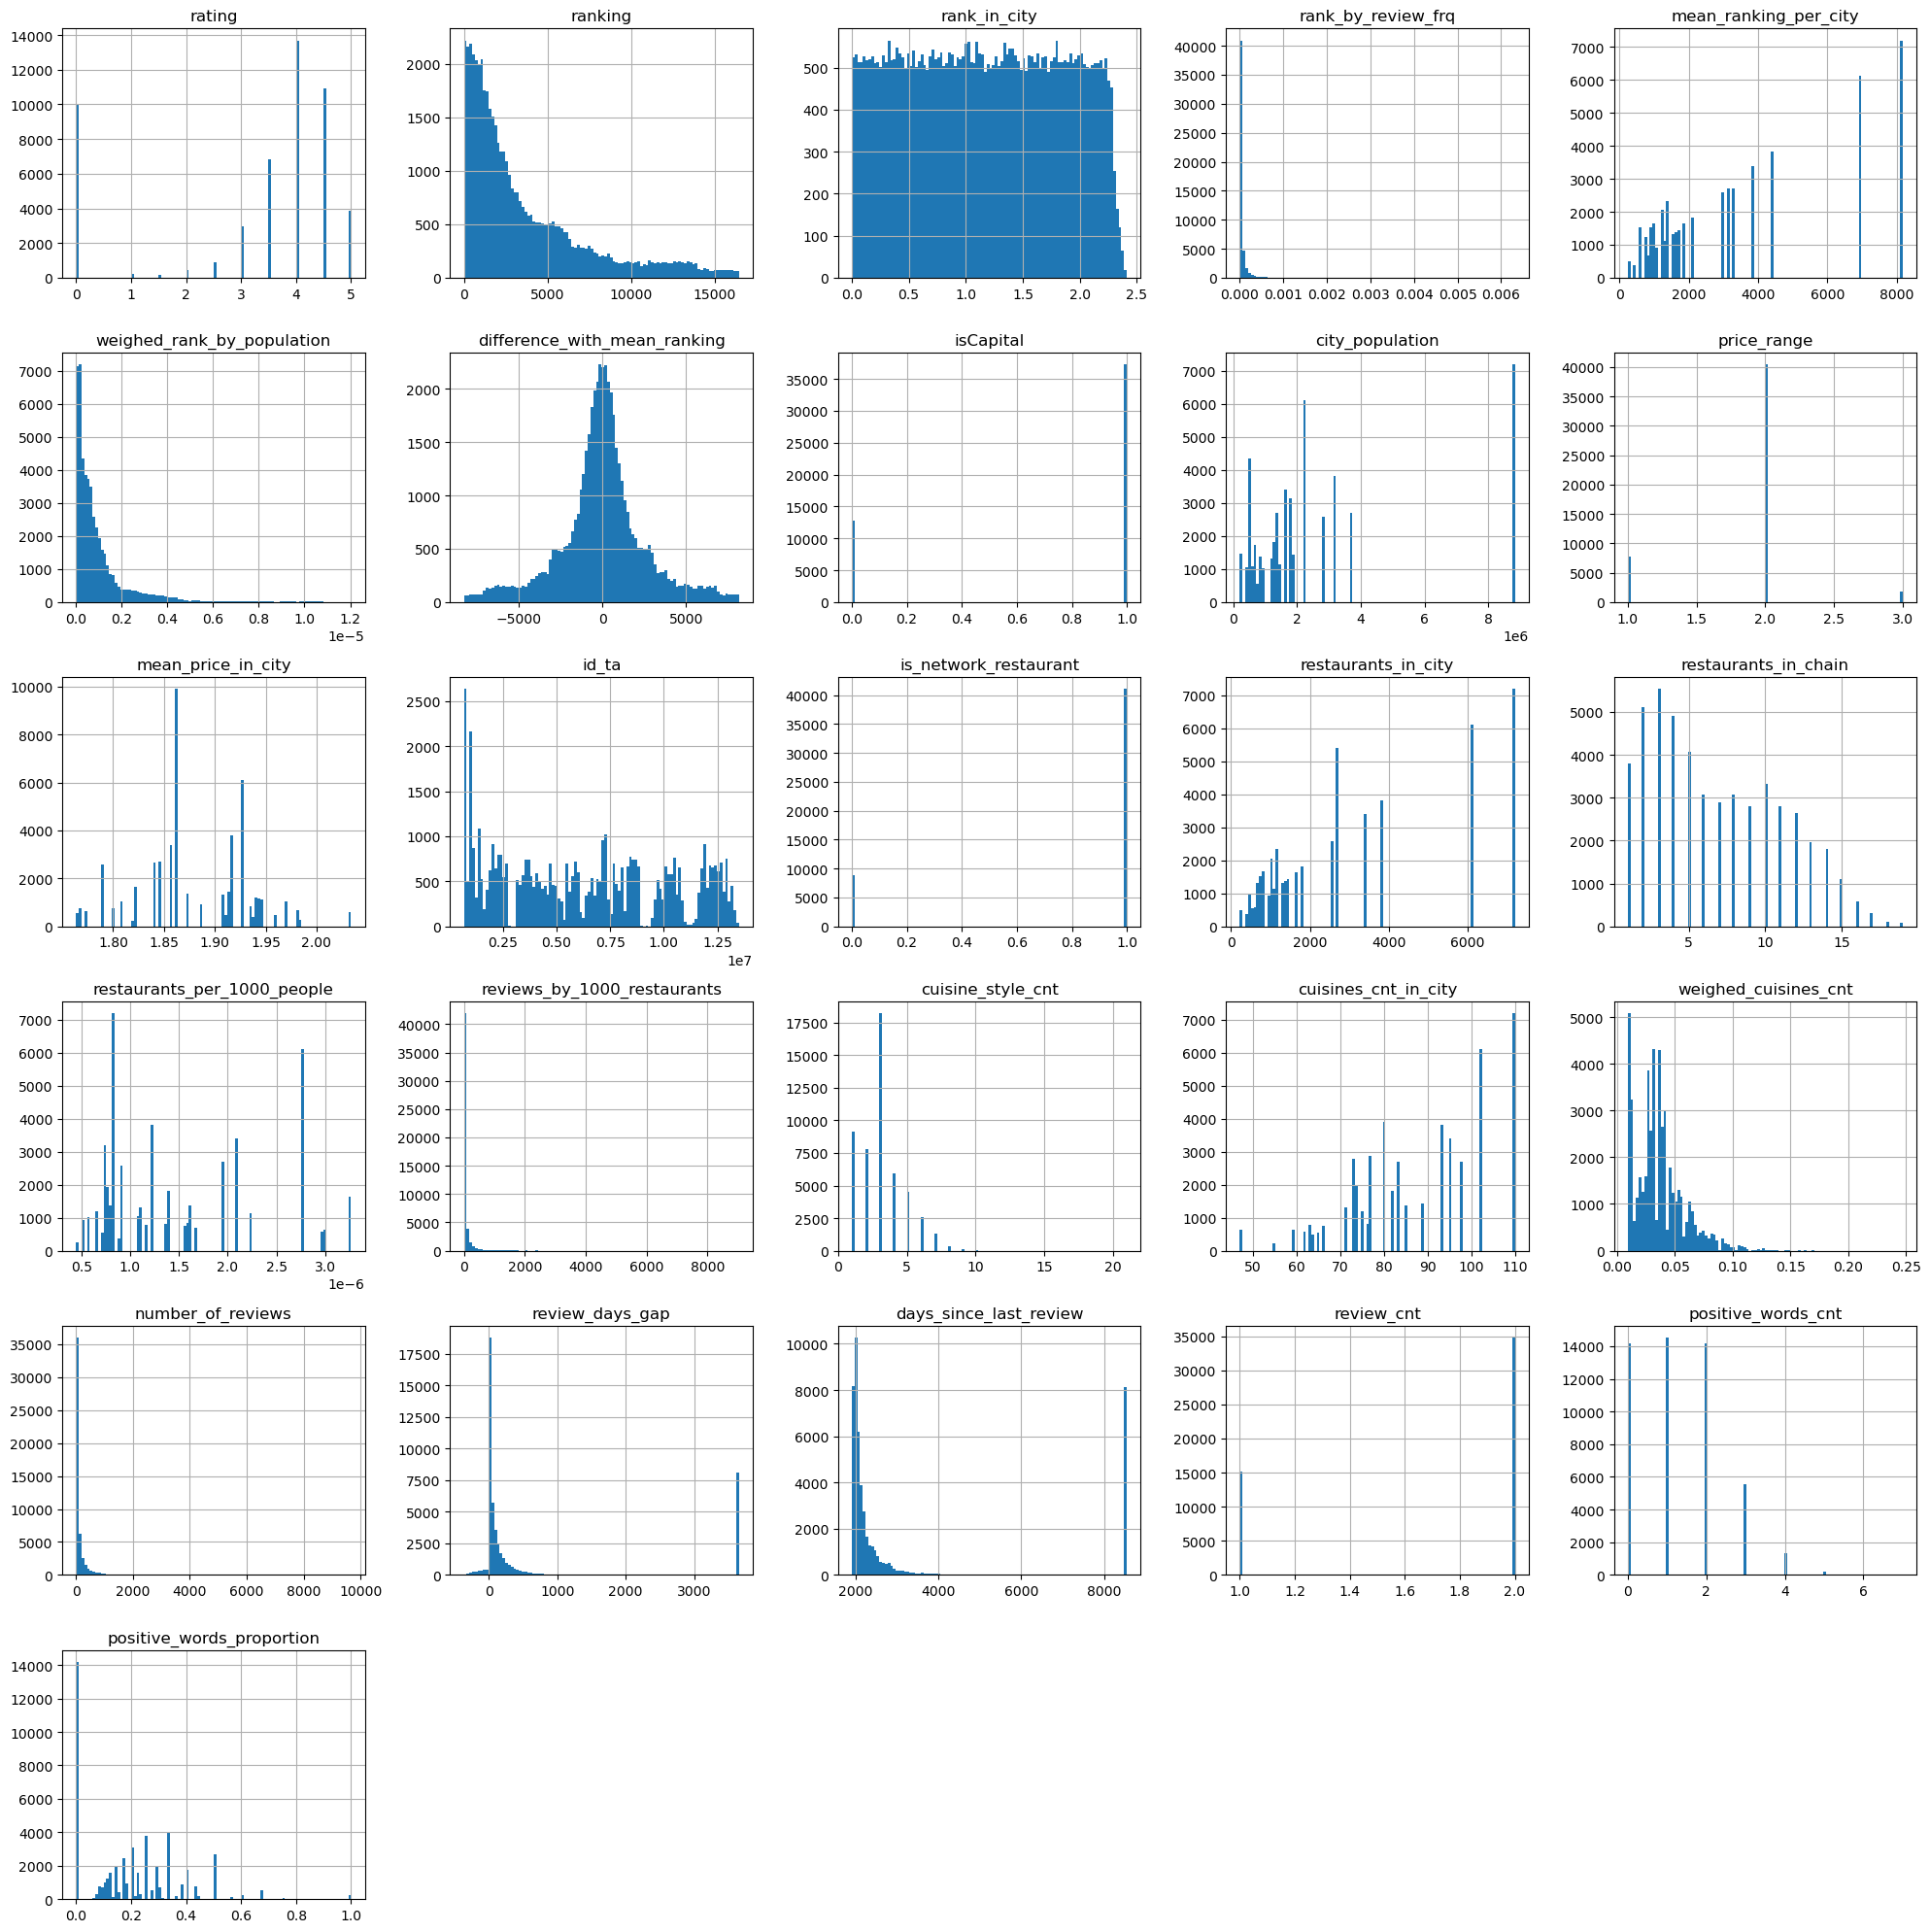

In [127]:
data[['rating', 'ranking', 'rank_in_city', 'rank_by_review_frq', 'mean_ranking_per_city', 
      'weighed_rank_by_population', 'difference_with_mean_ranking',  'isCapital',  'city_population', 
      'price_range', 'mean_price_in_city', 'restaurant_id', 'restaurant_net_id', 'id_ta', 'is_network_restaurant', 
      'restaurants_in_city', 'restaurants_in_chain', 'restaurants_per_1000_people', 'reviews_by_1000_restaurants', 
      'cuisine_style_сnt', 'cuisines_сnt_in_city', 'weighed_cuisines_cnt', 'number_of_reviews', 'review_days_gap', 
      'days_since_last_review', 'review_сnt', 'positive_words_cnt', 'positive_words_proportion']]  \
      .hist(figsize = (20, 20), bins = 100);
plt.tight_layout()

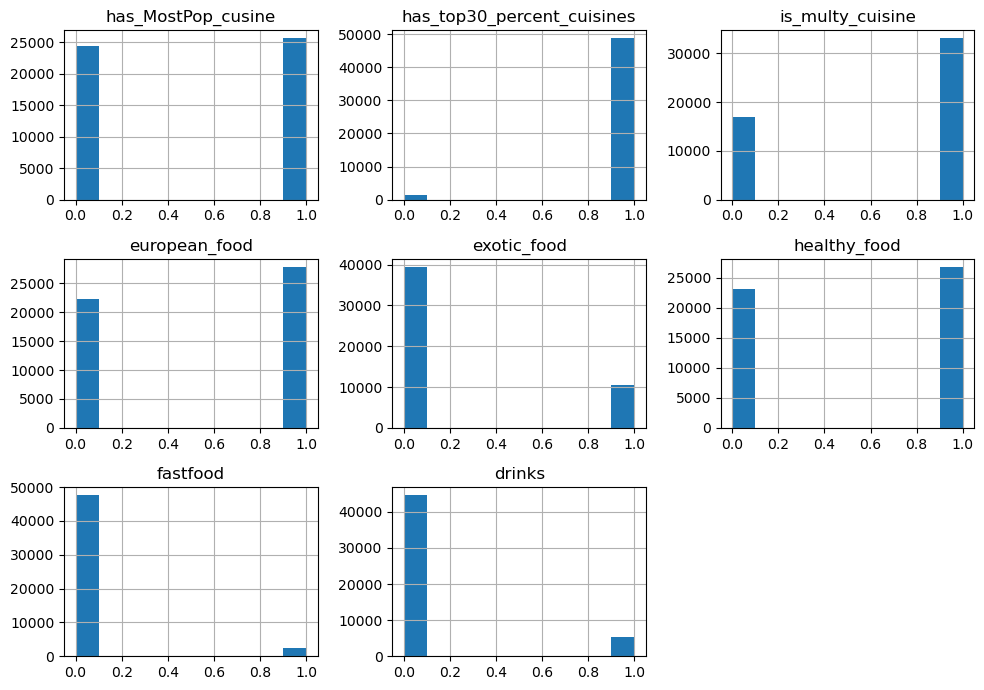

In [128]:
data[['has_MostPop_cusine', 'has_top30_percent_cuisines', 'is_multy_cuisine', 
      'european_food', 'exotic_food', 'healthy_food', 'fastfood', 'drinks']].hist(figsize = (10, 7));
plt.tight_layout()

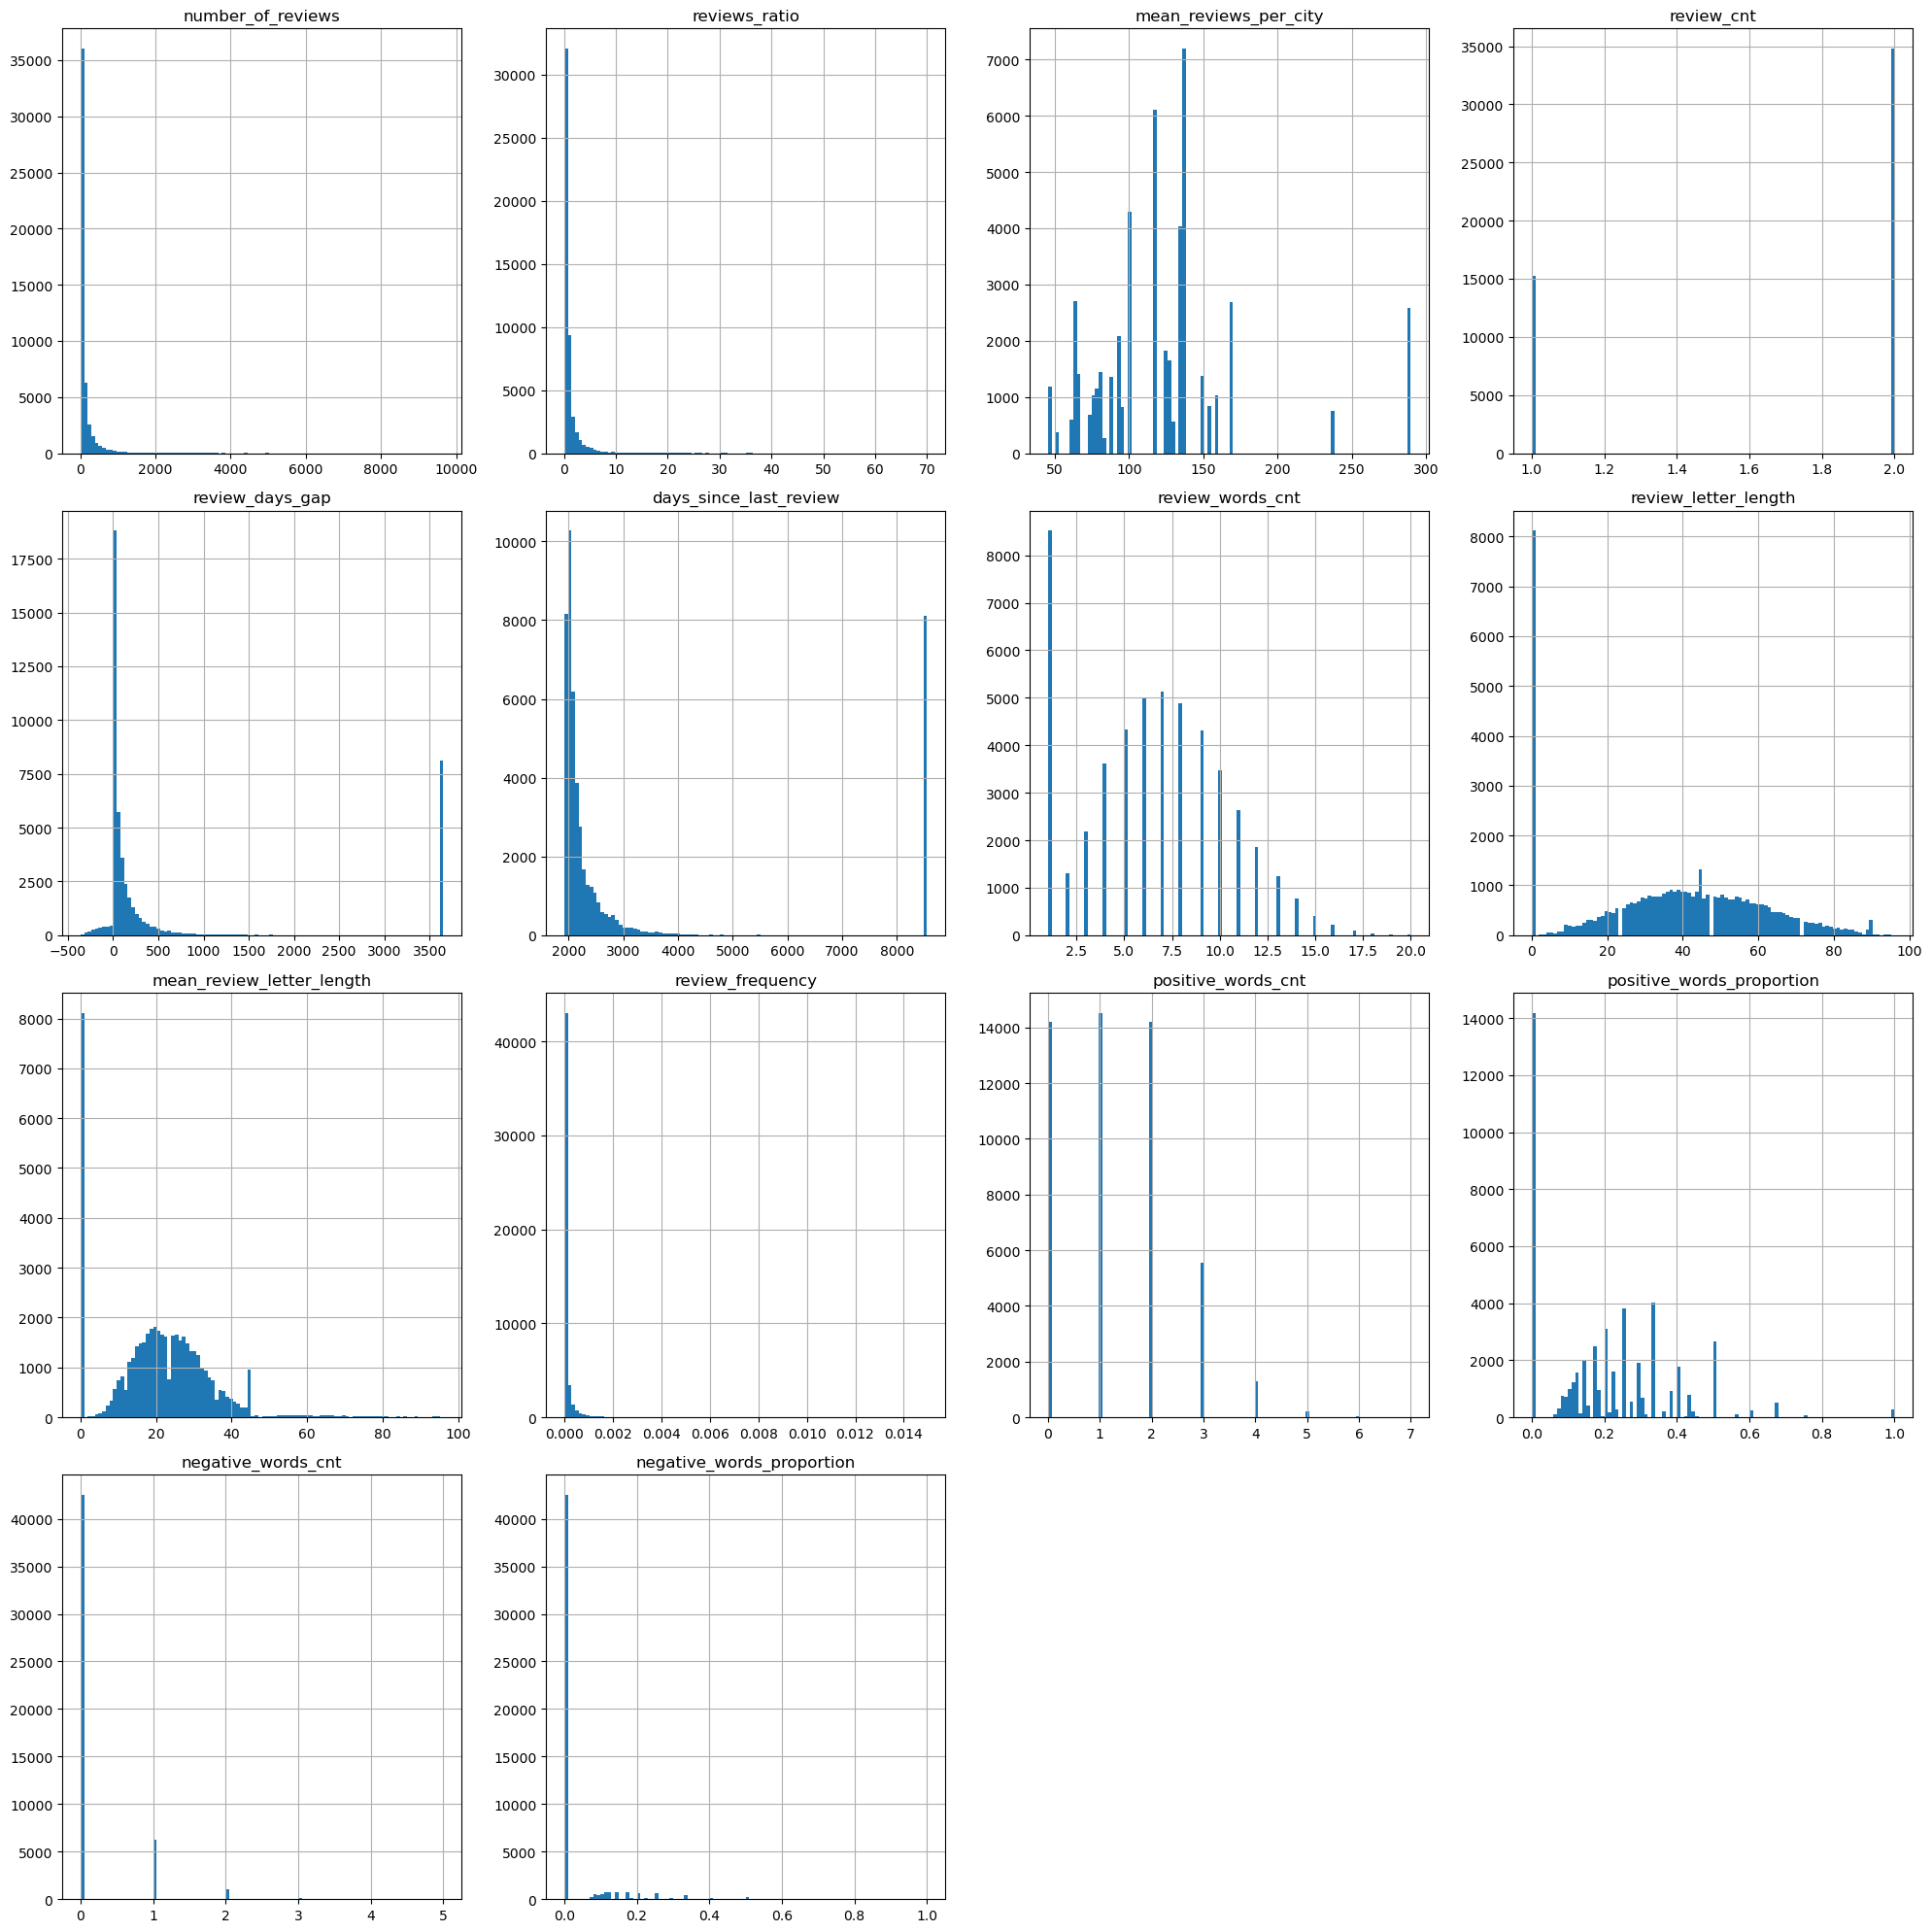

In [129]:
data[['number_of_reviews', 'reviews_ratio', 'mean_reviews_per_city', 'review_сnt', 'review_days_gap', 
      'days_since_last_review', 'review_words_cnt',  'review_letter_length', 'mean_review_letter_length', 
      'review_frequency', 'positive_words_cnt', 'positive_words_proportion', 'negative_words_cnt', 
      'negative_words_proportion']].hist(figsize = (20, 20), bins = 100);
plt.tight_layout()

<AxesSubplot:>

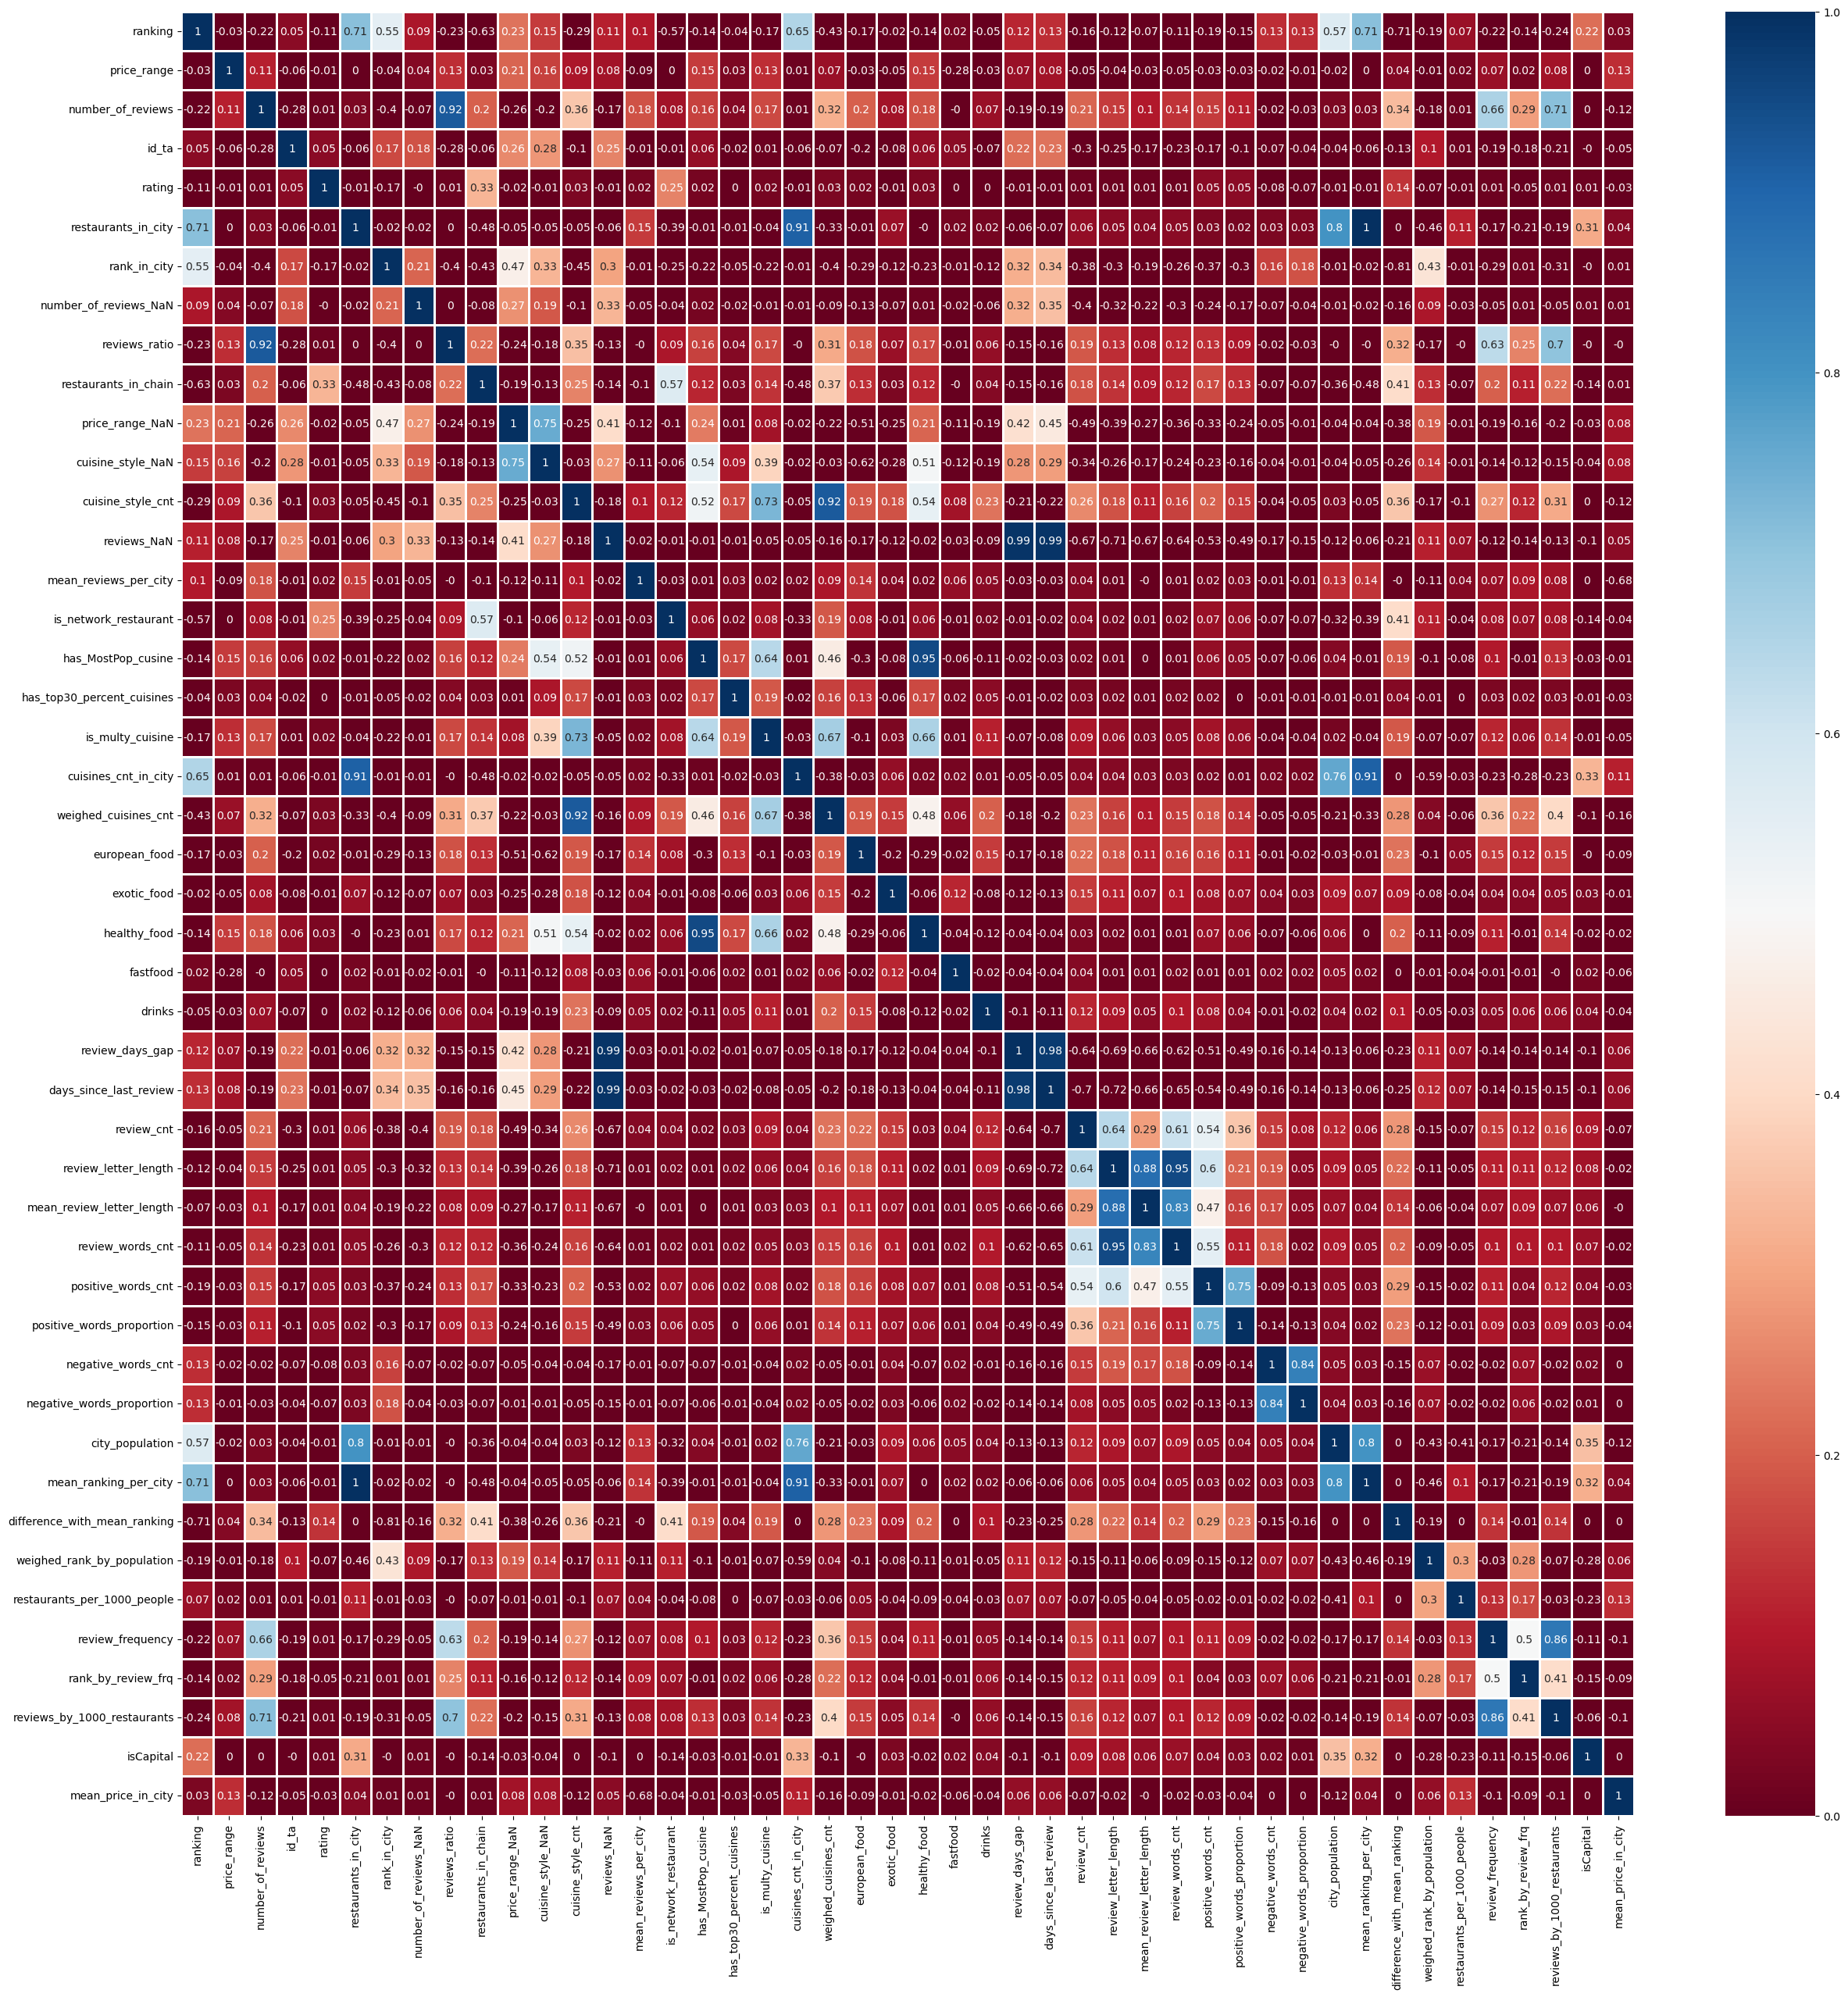

In [130]:
table_corr = data.drop(['restaurant_id', 'city', 'cuisine_style', 'reviews', 'url_ta', 'top_30_percent_cuisine', 
                        'review_dates', 'review_date_1', 'review_date_2', 'last_review_season','reviews_list', 
                        'unique_pos_words_list', 'unique_neg_words_list', 'country', 'top_cities', 
                        'sample'], axis = 1).corr().round(2)
plt.rcParams['figure.figsize'] = (30, 30)
sns.heatmap(table_corr, vmin = 0, vmax = 1, cmap = "RdBu", linewidths = 1, annot = True)

In [131]:
# Посмотрим какие признаки имеют более высокую корреляцию с целевой переменной 'rating'
table_corr['rating'].abs().sort_values(ascending = False)[:25]

rating                          1.00
restaurants_in_chain            0.33
is_network_restaurant           0.25
rank_in_city                    0.17
difference_with_mean_ranking    0.14
ranking                         0.11
negative_words_cnt              0.08
weighed_rank_by_population      0.07
negative_words_proportion       0.07
rank_by_review_frq              0.05
id_ta                           0.05
positive_words_proportion       0.05
positive_words_cnt              0.05
weighed_cuisines_cnt            0.03
healthy_food                    0.03
mean_price_in_city              0.03
cuisine_style_сnt               0.03
european_food                   0.02
price_range_NaN                 0.02
has_MostPop_cusine              0.02
mean_reviews_per_city           0.02
is_multy_cuisine                0.02
reviews_NaN                     0.01
exotic_food                     0.01
isCapital                       0.01
Name: rating, dtype: float64

### Преобразование категориальных признаков с помощью get.dummies

In [132]:
# Создаем dummy-переменные
city_dummies = pd.get_dummies(data.city, prefix = 'city')
country_dummies = pd.get_dummies(data.country, prefix = 'country')
# top_cities_dummies = pd.get_dummies(data.top_cities, prefix = 'top_city')
price_range_dummies = pd.get_dummies(data.price_range, prefix = 'price')
review_season_dummies = pd.get_dummies(data.last_review_season, prefix = 'review_season')
top_30_percent_cuisine_dum = pd.get_dummies(data.top_30_percent_cuisine.apply(pd.Series).stack(), prefix = 'cuisine') \
                             .sum(level = 0)
unique_pos_words_dum = pd.get_dummies(data['unique_pos_words_list'].apply(pd.Series).stack(), prefix = 'positive_word') \
                             .sum(level = 0)
unique_neg_words_dum = pd.get_dummies(data['unique_neg_words_list'].apply(pd.Series).stack(), prefix = 'negative_word') \
                             .sum(level = 0)

# Соединяем dummy-переменные
data = pd.concat([data, city_dummies, country_dummies, price_range_dummies, review_season_dummies, 
                  top_30_percent_cuisine_dum, unique_pos_words_dum, unique_neg_words_dum], axis = 1)

# Создаем список названий столбцов
city_cols = city_dummies.columns.tolist()
country_cols = country_dummies.columns.tolist()
price_range_cols = price_range_dummies.columns.tolist()
# top_cities_cols = top_cities_dummies.columns.tolist()
review_season_cols = review_season_dummies.columns.tolist()
top_30_percent_cuisine_cols = top_30_percent_cuisine_dum.columns.tolist()
unique_pos_words_cols = unique_pos_words_dum.columns.tolist()
unique_neg_words_cols = unique_neg_words_dum.columns.tolist()

# Собираем признаки 
cols = ['number_of_reviews', 'ranking', 'restaurants_per_1000_people', 'weighed_rank_by_population',
        'rank_by_review_frq', 'is_multy_cuisine','difference_with_mean_ranking', 'is_network_restaurant', 
        'negative_words_proportion', 'cuisines_сnt_in_city', 'id_ta', 'city_population', 'cuisine_style_сnt', 
        'restaurants_in_city', 'positive_words_proportion', 'rank_in_city', 'isCapital', 'mean_price_in_city', 
        'review_days_gap', 'days_since_last_review', 'healthy_food', 'european_food', 'number_of_reviews_NaN', 
        'cuisine_style_NaN', 'price_range_NaN', 'restaurants_in_chain', 'review_letter_length']  
cols.extend(city_cols)
cols.extend(country_cols)
cols.extend(price_range_cols)
cols.extend(review_season_cols)
cols.extend(top_30_percent_cuisine_cols)
cols.extend(unique_pos_words_cols)
cols.extend(unique_neg_words_cols)

In [141]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели
train_df = data[data['sample'] == 1].drop('sample', axis = 1)
test_df = data[data['sample'] == 0].drop(['sample', 'rating'], axis = 1)

X = train_df[cols]
y = train_df.rating

print(f'Размер train_df: {train_df.shape}, test_df: {test_df.shape}')   # train_df: (40000, 1544), test_df: (10000, 1543)
print('train_df')
display(train_df.head(2))

print('test_df')
display(test_df.head(2))

print(f'Размер матрицы X: {X.shape}, Размер y: {y.shape}')   #  X: (40000, 1509),  y: (40000,)
X.head()

#(10000, 1541), (10000, 2)

Размер train_df: (40000, 1544), test_df: (10000, 1543)
train_df


,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,rating,restaurants_in_city,rank_in_city,number_of_reviews_NaN,reviews_ratio,restaurants_in_chain,price_range_NaN,cuisine_style_NaN,cuisine_style_сnt,reviews_NaN,mean_reviews_per_city,restaurant_net_id,is_network_restaurant,has_MostPop_cusine,has_top30_percent_cuisines,top_30_percent_cuisine,is_multy_cuisine,cuisines_сnt_in_city,weighed_cuisines_cnt,european_food,exotic_food,healthy_food,fastfood,drinks,review_dates,review_date_1,review_date_2,review_days_gap,days_since_last_review,last_review_season,reviews_list,review_сnt,review_letter_length,mean_review_letter_length,review_words_cnt,positive_words_cnt,positive_words_proportion,unique_pos_words_list,negative_words_cnt,negative_words_proportion,unique_neg_words_list,...,negative_word_unfortunately,negative_word_unfriendly,negative_word_unhappy,negative_word_unhealthy,negative_word_unhelpful,negative_word_unkind,negative_word_unknown,negative_word_unlikely,negative_word_unlucky,negative_word_unnecessary,negative_word_unpleasant,negative_word_unpredictable,negative_word_unprofitable,negative_word_unreasonable,negative_word_unreasonably,negative_word_unreliable,negative_word_unsatisfactory,negative_word_unsophisticated,negative_word_unstable,negative_word_untouched,negative_word_unusual,negative_word_unusually,negative_word_unwanted,negative_word_unwelcome,negative_word_upset,negative_word_useless,negative_word_utterly,negative_word_vain,negative_word_vile,negative_word_vulgar,negative_word_warned,negative_word_warning,negative_word_waste,negative_word_wasted,negative_word_wasting,negative_word_weak,negative_word_weary,negative_word_weird,negative_word_wicked,negative_word_wild,negative_word_wildly,negative_word_wimpy,negative_word_woeful,negative_word_worn,negative_word_worried,negative_word_worry,negative_word_worse,negative_word_worst,negative_word_worthless,negative_word_wrong
10000,id_5569,Paris,"[European, French, International]",5570.0,2,194.0,"[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]",/Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html,1912643,3.5,6108,0.911919,0,1.657540,4,0,0,3.0,0,117.040915,5569,1,0,1,"[International, European, French]",1,102,0.029412,1,0,0,0,0,"[12/31/2017, 11/20/2017]",2017-12-31,2017-11-20,41,1975,winter,"[Good food at your doorstep, A good hotel restaurant]",2,49,24.5,9,2,0.22,[good],0,0.0,negative_words_NAN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10001,id_1535,Stockholm,[Vegetarian Friendly],1537.0,2,10.0,"[['Unique cuisine', 'Delicious Nepalese food'], ['07/06/2017', '06/19/2016']]",/Restaurant_Review-g189852-d7992032-Reviews-Buddha_Nepal-Stockholm.html,7992032,4.0,1033,1.487899,0,0.132983,11,1,1,3.0,0,75.197479,1535,1,1,1,[Vegetarian Friendly],1,77,0.038961,0,0,1,0,0,"[07/06/2017, 06/19/2016]",2017-07-06,2016-06-19,382,2153,summer,"[Unique cuisine, Delicious Nepalese food]",2,37,18.5,5,1,0.20,[delicious],0,0.0,negative_words_NAN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


test_df


,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,restaurants_in_city,rank_in_city,number_of_reviews_NaN,reviews_ratio,restaurants_in_chain,price_range_NaN,cuisine_style_NaN,cuisine_style_сnt,reviews_NaN,mean_reviews_per_city,restaurant_net_id,is_network_restaurant,has_MostPop_cusine,has_top30_percent_cuisines,top_30_percent_cuisine,is_multy_cuisine,cuisines_сnt_in_city,weighed_cuisines_cnt,european_food,exotic_food,healthy_food,fastfood,drinks,review_dates,review_date_1,review_date_2,review_days_gap,days_since_last_review,last_review_season,reviews_list,review_сnt,review_letter_length,mean_review_letter_length,review_words_cnt,positive_words_cnt,positive_words_proportion,unique_pos_words_list,negative_words_cnt,negative_words_proportion,unique_neg_words_list,city_population,...,negative_word_unfortunately,negative_word_unfriendly,negative_word_unhappy,negative_word_unhealthy,negative_word_unhelpful,negative_word_unkind,negative_word_unknown,negative_word_unlikely,negative_word_unlucky,negative_word_unnecessary,negative_word_unpleasant,negative_word_unpredictable,negative_word_unprofitable,negative_word_unreasonable,negative_word_unreasonably,negative_word_unreliable,negative_word_unsatisfactory,negative_word_unsophisticated,negative_word_unstable,negative_word_untouched,negative_word_unusual,negative_word_unusually,negative_word_unwanted,negative_word_unwelcome,negative_word_upset,negative_word_useless,negative_word_utterly,negative_word_vain,negative_word_vile,negative_word_vulgar,negative_word_warned,negative_word_warning,negative_word_waste,negative_word_wasted,negative_word_wasting,negative_word_weak,negative_word_weary,negative_word_weird,negative_word_wicked,negative_word_wild,negative_word_wildly,negative_word_wimpy,negative_word_woeful,negative_word_worn,negative_word_worried,negative_word_worry,negative_word_worse,negative_word_worst,negative_word_worthless,negative_word_wrong
0,id_0,Paris,"[Bar, Pub]",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html,10746918,6108,2.122299,0,0.034176,16,0,0,2.0,1,117.040915,0,1,0,1,"[Pub, Bar]",0,102,0.019608,0,0,0,0,1,[],2000-01-01,1990-01-01,3652,8549,winter,[],1,0,0.0,1,0,0.00,positive_words_NAN,0,0.0,negative_words_NAN,2206488,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, Vegetarian Friendly, Vegan Options]",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]",/Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html,6674944,475,0.223158,0,1.469249,10,0,0,5.0,0,66.020134,1,1,1,1,"[Other, Vegan Options, Gluten Free Options, Vegetarian Friendly, European]",1,71,0.070423,1,0,1,0,0,"[12/05/2017, 10/29/2017]",2017-12-05,2017-10-29,37,2001,winter,"[Very good reviews!, Fine dining in Hakaniemi]",2,42,21.0,7,2,0.29,"[fine, good]",0,0.0,negative_words_NAN,631695,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Размер матрицы X: (40000, 1509), Размер y: (40000,)


,number_of_reviews,ranking,restaurants_per_1000_people,weighed_rank_by_population,rank_by_review_frq,is_multy_cuisine,difference_with_mean_ranking,is_network_restaurant,negative_words_proportion,cuisines_сnt_in_city,id_ta,city_population,cuisine_style_сnt,restaurants_in_city,positive_words_proportion,rank_in_city,isCapital,mean_price_in_city,review_days_gap,days_since_last_review,healthy_food,european_food,number_of_reviews_NaN,cuisine_style_NaN,price_range_NaN,restaurants_in_chain,review_letter_length,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,...,negative_word_unfortunately,negative_word_unfriendly,negative_word_unhappy,negative_word_unhealthy,negative_word_unhelpful,negative_word_unkind,negative_word_unknown,negative_word_unlikely,negative_word_unlucky,negative_word_unnecessary,negative_word_unpleasant,negative_word_unpredictable,negative_word_unprofitable,negative_word_unreasonable,negative_word_unreasonably,negative_word_unreliable,negative_word_unsatisfactory,negative_word_unsophisticated,negative_word_unstable,negative_word_untouched,negative_word_unusual,negative_word_unusually,negative_word_unwanted,negative_word_unwelcome,negative_word_upset,negative_word_useless,negative_word_utterly,negative_word_vain,negative_word_vile,negative_word_vulgar,negative_word_warned,negative_word_warning,negative_word_waste,negative_word_wasted,negative_word_wasting,negative_word_weak,negative_word_weary,negative_word_weird,negative_word_wicked,negative_word_wild,negative_word_wildly,negative_word_wimpy,negative_word_woeful,negative_word_worn,negative_word_worried,negative_word_worry,negative_word_worse,negative_word_worst,negative_word_worthless,negative_word_wrong
10000,194.0,5570.0,2.768200e-06,4.132897e-07,0.000080,1,1368.557138,1,0.0,102,1912643,2206488,3.0,6108,0.22,0.911919,1,1.926981,41,1975,0,1,0,0,0,4,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10001,10.0,1537.0,1.085018e-06,1.562824e-06,0.000016,1,-299.517909,1,0.0,77,7992032,952058,3.0,1033,0.20,1.487899,1,1.969022,382,2153,1,0,0,1,1,11,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10002,688.0,353.0,8.150708e-07,5.560962e-09,0.000004,1,7816.707354,1,0.0,110,8632781,8825000,7.0,7193,0.17,0.049075,1,1.861949,2,1967,1,0,0,0,0,9,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Нормализация признаков

In [142]:
# Нормализуем числовые переменные 
scaler = MinMaxScaler()
normed_features = scaler.fit_transform(X[['number_of_reviews', 'ranking', 'weighed_rank_by_population',
                        'restaurants_per_1000_people', 'rank_by_review_frq','difference_with_mean_ranking', 
                        'is_network_restaurant', 'negative_words_proportion', 'cuisines_сnt_in_city', 'id_ta', 
                        'city_population', 'cuisine_style_сnt', 'restaurants_in_city', 'positive_words_proportion', 
                        'rank_in_city', 'mean_price_in_city', 'review_days_gap', 'days_since_last_review',
                        'restaurants_in_chain', 'review_letter_length']])

X[[ 'number_of_reviews', 'ranking', 'weighed_rank_by_population',
                        'restaurants_per_1000_people', 'rank_by_review_frq','difference_with_mean_ranking', 
                        'is_network_restaurant', 'negative_words_proportion', 'cuisines_сnt_in_city', 'id_ta', 
                        'city_population', 'cuisine_style_сnt', 'restaurants_in_city', 'positive_words_proportion', 
                        'rank_in_city', 'mean_price_in_city', 'review_days_gap', 'days_since_last_review',
                        'restaurants_in_chain', 'review_letter_length']] = normed_features

X.head(3)

,number_of_reviews,ranking,restaurants_per_1000_people,weighed_rank_by_population,rank_by_review_frq,is_multy_cuisine,difference_with_mean_ranking,is_network_restaurant,negative_words_proportion,cuisines_сnt_in_city,id_ta,city_population,cuisine_style_сnt,restaurants_in_city,positive_words_proportion,rank_in_city,isCapital,mean_price_in_city,review_days_gap,days_since_last_review,healthy_food,european_food,number_of_reviews_NaN,cuisine_style_NaN,price_range_NaN,restaurants_in_chain,review_letter_length,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,...,negative_word_unfortunately,negative_word_unfriendly,negative_word_unhappy,negative_word_unhealthy,negative_word_unhelpful,negative_word_unkind,negative_word_unknown,negative_word_unlikely,negative_word_unlucky,negative_word_unnecessary,negative_word_unpleasant,negative_word_unpredictable,negative_word_unprofitable,negative_word_unreasonable,negative_word_unreasonably,negative_word_unreliable,negative_word_unsatisfactory,negative_word_unsophisticated,negative_word_unstable,negative_word_untouched,negative_word_unusual,negative_word_unusually,negative_word_unwanted,negative_word_unwelcome,negative_word_upset,negative_word_useless,negative_word_utterly,negative_word_vain,negative_word_vile,negative_word_vulgar,negative_word_warned,negative_word_warning,negative_word_waste,negative_word_wasted,negative_word_wasting,negative_word_weak,negative_word_weary,negative_word_weird,negative_word_wicked,negative_word_wild,negative_word_wildly,negative_word_wimpy,negative_word_woeful,negative_word_worn,negative_word_worried,negative_word_worry,negative_word_worse,negative_word_worst,negative_word_worthless,negative_word_wrong
10000,0.020083,0.338685,0.824337,0.034336,0.012697,1,0.586441,1.0,0.0,0.873016,0.096073,0.232727,0.1,0.844355,0.22,0.377868,1,0.604538,0.100399,0.008596,0,1,0,0,0,0.166667,0.510417,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10001,0.001035,0.093414,0.227030,0.129844,0.002475,1,0.484995,1.0,0.0,0.476190,0.570024,0.087303,0.1,0.116339,0.20,0.616570,1,0.760039,0.185351,0.035440,1,0,0,1,1,0.555556,0.385417,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10002,0.071222,0.021407,0.131234,0.000461,0.000606,1,0.978593,1.0,0.0,1.000000,0.619977,1.000000,0.3,1.000000,0.17,0.020281,1,0.364000,0.090683,0.007390,1,0,0,0,0,0.444444,0.375000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 6. Формирование класса 

In [146]:
class RestRatingPreprocessor():
    def __init__(self, train_df, test_df, sample_submission):
        '''Функция инициализации'''
        
        self.train_df = train_df
        self.test_df = test_df
        self.sample_submission = sample_submission
        self.pos_words_list = positive_words_df[0].to_list()
        self.neg_words_list = negative_words_df[0].to_list()
        self.population_df = population_df
        self.city_df = city_df
        self.train_df['sample'] = 1   # Помечаем где трейн и тест
        self.test_df['sample'] = 0
        self.test_df['Rating'] = 0 
        self.data = test_df.append(train_df, sort = False).reset_index(drop = True) # Объединяем трейн и тест для обработки
        self.data.drop('URL_TA', axis = 1, inplace = True) 
        self.data.columns = self.data.columns.str.lower().str.replace(' ', '_')
    
    
    def cleaning(self):
        '''Очистка данных и заполнение пропусков'''
        
        # Признак "id_ta"
        self.data['id_ta'] = self.data['id_ta'].apply(lambda x: x[1:]).astype('int')
        
        # Признак "price_range" 
        # Перекодируем признак, выведем инф-ю о пропусках в отдельный столбец и заполним пропуски наиболее частым значением
        self.data['price_range_NaN'] = self.data['price_range'].isna().astype('uint8')
        self.price_dict = {'$' : 1, '$$ - $$$' : 2, '$$$$' : 3, np.NaN : 2}
        self.data['price_range'] = self.data['price_range'].replace(to_replace = price_dict).apply(lambda x: int(x))
        
        # Признак "cuisine_style"
        # Очистим признак и преобразуем его в формат списка с видами кухонь, заполним пропуски  
        self.data['cuisine_style_NaN'] = self.data.cuisine_style.isna().astype('uint8')
        self.data['cuisine_style'] = self.data['cuisine_style'].apply(lambda x: str(x).replace('[', '') \
                                     .replace(']', '').replace("'", '').split(', '))
        cuisine_style_counter = Counter()
        for row in self.data['cuisine_style']:
            for cuisine in row:
                cuisine_style_counter[cuisine] += 1
        most_pop_cuisine = cuisine_style_counter.most_common()[0][0]
        self.data.cuisine_style = self.data.cuisine_style.apply(lambda x: ([most_pop_cuisine]) if x == ['nan'] else x)
        
        # Признак "reviews"
        # Заполним пропуски значением '[[], []]', выведем информацию о пропусках в отдельный столбец
        self.data['reviews'].fillna('[[], []]', inplace = True)
        self.data['reviews_NaN'] = (self.data.reviews == '[[], []]').astype('int')
        # Получаем "review_date_1" и "review_date_2": даты двух последних отзывов в формате datetime и заполняем пропуски
        self.data['review_date_1'] = self.data['reviews'].apply(lambda x: re.findall(r'\d\d\/\d\d\/\d{4}', x)) \
                                    .apply(lambda row: get_review_date_1(row))
        self.data['review_date_2'] = self.data['reviews'].apply(lambda x: re.findall(r'\d\d\/\d\d\/\d{4}', x))  \
                                    .apply(lambda row: get_review_date_2(row))
        self.data['review_date_1'] = self.data['review_date_1'].fillna(datetime(2000,1,1,))
        self.data['review_date_2'] = self.data['review_date_2'].fillna(datetime(1990,1,1,))
        # Получаем "reviews_list" - список из двух последних отзывов
        self.data['reviews_list'] = self.data['reviews'].apply(lambda x: re.split(r'\d\d\/\d\d\/\d{4}', x))  \
                                    .apply(lambda x: x[0]).apply(lambda x: x.strip("[],' "))  \
                                    .apply(lambda x: x.split("', '"))
        
        # Признак "number_of_reviews"
        self.data['number_of_reviews_NaN'] = self.data.number_of_reviews.isna().astype('uint8')
        # Создадим новый столбец - среднее кол-во отзывов по городу
        # Заполним пропуски: для тех ресторанов, у которых нет отзывов в базе данных, ставим "0"   
        # Оставшиеся пропуски заполним средним количеством отзывов по городу   
        mean_reviews_per_city_df = self.data.groupby('city', as_index = False) \
                                   .agg(mean_reviews_per_city = ('number_of_reviews', 'mean'))
        self.data = self.data.merge(mean_reviews_per_city_df, on = 'city', how = 'left')
        ind = self.data[(self.data.reviews_NaN == 1) & (self.data.number_of_reviews_NaN == 1)].number_of_reviews \
              .index.to_list()
        self.data.number_of_reviews.iloc[ind] = self.data.number_of_reviews.iloc[ind].fillna(0)
        self.data['number_of_reviews'].fillna(self.data['mean_reviews_per_city'], inplace = True)
            
    
    def feature_engeneering(self):
        '''Генерация новых признаков'''
        
        # Количество ресторанов в городе
        self.data['restaurants_in_city'] = self.data.city.map(restaurants_in_city)
        
        # Количество ресторанов в сети
        id_dict = self.data['restaurant_id'].value_counts().to_dict()
        self.data['restaurants_in_chain'] = self.data['restaurant_id'].apply(lambda s: id_dict[s])
        
        # Отношение ранга каждого ресторана к общему количеству ресторанов в данном городе 
        self.data['rank_in_city'] = self.data.ranking / self.data.restaurants_in_city
        
        # Отношение кол-ва отзывов каждого отдельного ресторана к среднему кол-ву отзывов в данном городе
        mean_reviews_per_city = self.data.groupby('city').number_of_reviews.mean()
        self.data['reviews_ratio'] = self.data.number_of_reviews / self.data.city.apply(lambda x: mean_reviews_per_city[x])
        self.data.reviews_ratio.fillna(self.data.reviews_ratio.mean(), inplace = True)
        
        # Количество видов кухонь в ресторане
        self.data['cuisine_style_сnt'] = self.data.cuisine_style  \
                                        .apply(lambda x: len(x) if x != ['nan'] else median_num_cuisine_style)
        
        # Явлется ли ресторан сетевым (1\0)
        self.data['restaurant_net_id'] = self.data.restaurant_id.apply(lambda x: x.split('_')[1])
        is_network_restaurant = (self.data['restaurant_net_id'].value_counts() >= 2).astype('int')
        self.data['is_network_restaurant']  = self.data['restaurant_net_id'].map(is_network_restaurant) 
        
        # Наличие в ресторане самой популярной кухни (1/0)
        self.data['has_MostPop_cusine'] = self.data.cuisine_style.apply(lambda x: 1 if most_pop_cuisine in x else 0)
        
        # Наличие в ресторане 30% наиболее популярных видов кухни (1/0)
        threshold = int(np.percentile(list(dict(cuisine_style_counter.most_common()).values()),30))
        top_30_percent_cuisines_list = list(dict(cuisine_style_counter.most_common()).keys())[:threshold]
        self.data['has_top30_percent_cuisines'] = self.data['cuisine_style'] \
            .apply(lambda x: max([1 if i in top_30_percent_cuisines_list else 0 for i in x]))

        # Cписок кухонь, входящих в 30% наиболее популярных, для остальных - "Other"
        self.data['top_30_percent_cuisine'] = self.data['cuisine_style']  \
            .apply(lambda x: list(set(list(i if i in top_30_percent_cuisines_list else 'Other' for i in x))))

        # Кол-во кухонь в ресторане больше или меньше среднего 
        self.data['is_multy_cuisine'] = self.data.cuisine_style_сnt \
                                        .apply(lambda x: 1 if  x >= round(mean_num_cuisine_style) else 0)  
        
        # Количество видов кухонь в городе
        cuisines_сnt_in_city_dict = dict(map(lambda x: (x[0], len(set(x[1]))), self.data.groupby('city').cuisine_style \
                                     .sum().to_dict().items()))
        self.data['cuisines_сnt_in_city'] = self.data['city'].map(cuisines_сnt_in_city_dict)

        # Относительная доля кухонь в ресторане
        self.data['weighed_cuisines_cnt'] = self.data['cuisine_style_сnt'] / self.data['cuisines_сnt_in_city'] 
        
        # Местная, экзотическая, здоровая кухня, фаст-фуд и напитки
        self.data['european_food'] = self.data['cuisine_style'].apply(lambda x: sorted(set(1 if i in european_food else 0 for i in x))[-1])
        self.data['exotic_food'] = self.data['cuisine_style'].apply(lambda x: sorted(set(1 if i in exotic_food else 0 for i in x))[-1])
        self.data['healthy_food'] = self.data['cuisine_style'].apply(lambda x: sorted(set(1 if i in healthy_food else 0 for i in x))[-1])
        self.data['fastfood'] = self.data['cuisine_style'].apply(lambda x: sorted(set(1 if i in fastfood else 0 for i in x))[-1])
        self.data['drinks'] = self.data['cuisine_style'].apply(lambda x: sorted(set(1 if i in drinks else 0 for i in x))[-1])

        # Количество дней между двумя последними отзывами
        self.data = self.data.assign(review_days_gap = lambda x: ((x['review_date_1'] - x['review_date_2']).dt.days))

        # Количество дней, прошедших с публикации последнего отзыва
        current_date = datetime.today()
        self.data['days_since_last_review'] = (current_date - (self.data[['review_date_1','review_date_2']].max(axis=1))).dt.days

        # Время года, когда был оставлен последний отзыв
        self.data['last_review_season'] = self.data[['review_date_1', 'review_date_2']].max(axis=1).apply(get_last_review_season)

        
        # Кол-во представленных в базе данных отзывов
        self.data['review_сnt'] = self.data.reviews_list.apply(lambda x: len(x))

        # Общая длина последних отзывов (побуквенно)
        self.data['review_letter_length'] = self.data['reviews_list']  \
                                .apply(lambda x: len(x[0]) if len(x) == 1 else len(x[0]) + len(x[1]) if len(x) > 1 else np.NaN)
        
        # Средняя длина последних отзывов (побуквенно)
        self.data['mean_review_letter_length'] = self.data['reviews_list']  \
                                .apply(lambda x: len(x[0]) if len(x) == 1 else (len(x[0]) + len(x[-1])) / 2) 

        # Общее количество слов в отзыве
        self.data['review_words_cnt'] = self.data.reviews_list.apply(lambda x: get_words_cnt(x))

        # Кол-во позитивно окрашенных слов в отзывах
        self.data['positive_words_cnt'] = self.data.reviews_list.apply(lambda x: get_positive_words_cnt(x))

        # Пропорция позитивно окрашенных слов от общего кол-ва слов в отзывах 
        self.data['positive_words_proportion'] = self.data.reviews_list.apply(lambda x: get_positive_words_proportion(x))

        # Список уникальных позитивно окрашенных слов в отзывах
        self.data['unique_pos_words_list'] = self.data.reviews_list.apply(lambda x: get_unique_pos_words_list(x))

        # Кол-во негативно окрашенных слов в отзывах
        self.data['negative_words_cnt'] = self.data.reviews_list.apply(lambda x: get_negative_words_cnt(x))

        # Пропорция негативно окрашенных слов от общего кол-ва слов в отзывах 
        self.data['negative_words_proportion'] = self.data.reviews_list.apply(lambda x: get_negative_words_proportion(x))

        # Список уникальных негативно окрашенных слов в отзывах
        self.data['unique_neg_words_list'] = self.data.reviews_list.apply(lambda x: get_unique_neg_words_list(x))

        # Заполняем пропуски в списках уникальных позитивных и негативных слов  
        self.data['unique_pos_words_list'] = self.data['unique_pos_words_list'].fillna('positive_words_NAN')
        self.data['unique_neg_words_list'] = self.data['unique_neg_words_list'].fillna('negative_words_NAN')        
        
        # Население городов 
        population_df.columns = population_df.columns.str.lower()
        self.data = self.data.merge(population_df[['city', 'population']], on = 'city', how = 'left')  \
                    .rename(columns = {'population' : 'city_population'})
        
        # Страна 
        country_dict = population_df.groupby('city').country.sum().to_dict()
        self.data['country'] = self.data.city.map(country_dict)

        # Cредний ренкинг (ranking) ресторанов по каждому городу
        mean_ranking = data.groupby('city').ranking.mean()
        self.data['mean_ranking_per_city'] = self.data.city.apply(lambda x: mean_ranking[x])

        # Расстояние до среднего по городу ренкинга 
        self.data['difference_with_mean_ranking'] = self.data.mean_ranking_per_city - self.data.ranking

        # Зависимость взвешенного ренкинга ресторана от населения города
        self.data['weighed_rank_by_population'] = self.data['rank_in_city']  / self.data['city_population'] 

        # Кол-во ресторанов на 1000 человек населения
        self.data['restaurants_per_1000_people']  = self.data['restaurants_in_city'] / (self.data['city_population'] *1000)

        # Как часто в городе оставляют отзывы
        self.data['review_frequency'] = self.data['number_of_reviews'] / self.data['city_population']

        # Ранг ресторана с учетом частоты отзывов в городе
        self.data['rank_by_review_frq'] =  self.data['rank_in_city']  *  self.data['review_frequency'] 

        # Количество отзывов на тысячу ресторанов в городе
        self.data['reviews_by_1000_restaurants'] = self.data['number_of_reviews'] / self.data['restaurants_in_city'] * 1000

        # Ресторан расположен в столице (1\0)
        list_of_capitals = city_df[city_df.capital == 'primary'].city_ascii.unique().tolist()
        self.data['isCapital'] = self.data.apply(lambda x: get_isCapital(x), axis = 1)

        # Помечаем, входит ли город в топ-10 городов, если ДА, то пишем его назавние, если НЕТ - "other_city"
        top_cities = self.data['city'].value_counts()[0:10].index.to_list()
        self.data['top_cities'] = self.data.city.apply(lambda x: x if x in top_cities else 'other_city')

        # Средняя цена в городе
        mean_price_range_perCity = self.data.groupby('city')['price_range'].mean().to_dict()
        self.data['mean_price_in_city'] = self.data['city'].apply(lambda x: mean_price_range_perCity[x])
     
    
    def concat_dummies(self):
        '''Добавление дамми-переменных'''     
        
        # Создаем dummy-переменные
        city_dummies = pd.get_dummies(self.data.city, prefix = 'city')
        country_dummies = pd.get_dummies(self.data.country, prefix = 'country')
        price_range_dummies = pd.get_dummies(self.data.price_range, prefix = 'price')
        review_season_dummies = pd.get_dummies(self.data.last_review_season, prefix = 'review_season')
        top_30_percent_cuisine_dum = pd.get_dummies(self.data.top_30_percent_cuisine.apply(pd.Series)  \
                                      .stack(), prefix = 'cuisine').sum(level = 0)
        unique_pos_words_dum = pd.get_dummies(self.data['unique_pos_words_list'].apply(pd.Series)  \
                                      .stack(), prefix = 'positive_word').sum(level = 0)
        unique_neg_words_dum = pd.get_dummies(self.data['unique_neg_words_list'].apply(pd.Series)  \
                                      .stack(), prefix = 'negative_word').sum(level = 0)

        # Соединяем dummy-переменные
        self.data = pd.concat([self.data, city_dummies, country_dummies, price_range_dummies, review_season_dummies, 
                  top_30_percent_cuisine_dum, unique_pos_words_dum, unique_neg_words_dum], axis = 1)

        # Создаем список названий столбцов
        city_cols = city_dummies.columns.tolist()
        country_cols = country_dummies.columns.tolist()
        price_range_cols = price_range_dummies.columns.tolist()
        review_season_cols = review_season_dummies.columns.tolist()
        top_30_percent_cuisine_cols = top_30_percent_cuisine_dum.columns.tolist()
        unique_pos_words_cols = unique_pos_words_dum.columns.tolist()
        unique_neg_words_cols = unique_neg_words_dum.columns.tolist()

        # Собираем признаки 
        cols = ['number_of_reviews', 'ranking',  'restaurants_per_1000_people', 'weighed_rank_by_population',
                'rank_by_review_frq', 'is_multy_cuisine','difference_with_mean_ranking', 'is_network_restaurant', 
                'negative_words_proportion', 'cuisines_сnt_in_city', 'id_ta', 'city_population', 'cuisine_style_сnt', 
                'restaurants_in_city', 'positive_words_proportion', 'rank_in_city', 'isCapital','mean_price_in_city', 
                'review_days_gap', 'days_since_last_review', 'healthy_food', 'european_food', 'number_of_reviews_NaN', 
                'cuisine_style_NaN', 'price_range_NaN', 'restaurants_in_chain','review_letter_length']  
        cols.extend(city_cols)
        cols.extend(country_cols)
        cols.extend(price_range_cols)
        cols.extend(review_season_cols)
        cols.extend(top_30_percent_cuisine_cols)
        cols.extend(unique_pos_words_cols)
        cols.extend(unique_neg_words_cols)  
                
        
    def normalization(self):
        '''Нормализация числовых признаков'''
        
        scaler = MinMaxScaler()
        normed_features = scaler.fit_transform(self.data[['number_of_reviews', 'ranking', 'weighed_rank_by_population',
                        'restaurants_per_1000_people', 'rank_by_review_frq','difference_with_mean_ranking', 
                        'is_network_restaurant', 'negative_words_proportion', 'cuisines_сnt_in_city', 'id_ta', 
                        'city_population', 'cuisine_style_сnt', 'restaurants_in_city', 'positive_words_proportion', 
                        'rank_in_city', 'mean_price_in_city', 'review_days_gap', 'days_since_last_review',
                        'restaurants_in_chain', 'review_letter_length']])
        self.data[['number_of_reviews', 'ranking', 'weighed_rank_by_population', 'restaurants_per_1000_people', 
                   'rank_by_review_frq','difference_with_mean_ranking', 'is_network_restaurant', 'negative_words_proportion', 
                   'cuisines_сnt_in_city', 'id_ta', 'city_population', 'cuisine_style_сnt', 'restaurants_in_city', 
                   'positive_words_proportion', 'rank_in_city','mean_price_in_city', 'review_days_gap', 
                   'days_since_last_review', 'restaurants_in_chain', 'review_letter_length']] = normed_features          
        
    def run_preprocessing(self):
        '''Выполнение всех действий'''
        
        self.cleaning()
        self.feature_engeneering()
        self.concat_dummies()
        self.normalization()
    
    def get_train_and_test_df(self):
        '''Разбиение на train и test'''
        train_df = self.data[data['sample'] == 1].drop('sample', axis = 1)
        test_df = self.data[data['sample'] == 0].drop(['sample', 'rating'], axis = 1)
        return (train_df, test_df)
        
    def get_X_y(self):
        '''Разбиение на X и y'''
        
        X = train_df[cols]
        y = train_df.rating
        return (X,y)

In [147]:
# ЗАГРУЗИМ ДАННЫЕ
train_df = pd.read_csv('main_task_restaurant.csv')
test_df = pd.read_csv('kaggle_task_restaurant.csv')
sample_submission = pd.read_csv('sample_submission_restaurant.csv')

# Подготовим данные, запустив класс RestRatingPreprocessor, разделим данные на X и y
prepared_df = RestRatingPreprocessor(train_df, test_df, sample_submission)
prepared_df.run_preprocessing()
train_df, test_df = prepared_df.get_train_and_test_df()
X, y = prepared_df.get_X_y()

print(f'Размер train_df: {train_df.shape}, test_df: {test_df.shape}, sample_submission: {sample_submission.shape}')   
# train_df: (40000, 1542), test_df: (10000, 1541), sample_submission: (10000, 2)

print('\ntrain_df')
display(train_df.head(2))
print('\ntest_df')
display(test_df.head(2))
print('\nsample_submission')
display(sample_submission.head(2))

print(f'\nРазмер матрицы X: {X.shape}, Размер y: {y.shape}')   #  X: (40000, 1509),  y: (40000,)
display(X.head())

Размер train_df: (40000, 1542), test_df: (10000, 1541), sample_submission: (10000, 2)

train_df


,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,id_ta,rating,price_range_NaN,cuisine_style_NaN,reviews_NaN,review_date_1,review_date_2,reviews_list,number_of_reviews_NaN,mean_reviews_per_city,restaurants_in_city,restaurants_in_chain,rank_in_city,reviews_ratio,cuisine_style_сnt,restaurant_net_id,is_network_restaurant,has_MostPop_cusine,has_top30_percent_cuisines,top_30_percent_cuisine,is_multy_cuisine,cuisines_сnt_in_city,weighed_cuisines_cnt,european_food,exotic_food,healthy_food,fastfood,drinks,review_days_gap,days_since_last_review,last_review_season,review_сnt,review_letter_length,mean_review_letter_length,review_words_cnt,positive_words_cnt,positive_words_proportion,unique_pos_words_list,negative_words_cnt,negative_words_proportion,unique_neg_words_list,city_population,country,...,negative_word_unfortunately,negative_word_unfriendly,negative_word_unhappy,negative_word_unhealthy,negative_word_unhelpful,negative_word_unkind,negative_word_unknown,negative_word_unlikely,negative_word_unlucky,negative_word_unnecessary,negative_word_unpleasant,negative_word_unpredictable,negative_word_unprofitable,negative_word_unreasonable,negative_word_unreasonably,negative_word_unreliable,negative_word_unsatisfactory,negative_word_unsophisticated,negative_word_unstable,negative_word_untouched,negative_word_unusual,negative_word_unusually,negative_word_unwanted,negative_word_unwelcome,negative_word_upset,negative_word_useless,negative_word_utterly,negative_word_vain,negative_word_vile,negative_word_vulgar,negative_word_warned,negative_word_warning,negative_word_waste,negative_word_wasted,negative_word_wasting,negative_word_weak,negative_word_weary,negative_word_weird,negative_word_wicked,negative_word_wild,negative_word_wildly,negative_word_wimpy,negative_word_woeful,negative_word_worn,negative_word_worried,negative_word_worry,negative_word_worse,negative_word_worst,negative_word_worthless,negative_word_wrong
10000,id_5569,Paris,"[European, French, International]",0.338685,2,0.020083,"[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]",0.096073,3.5,0,0,0,2017-12-31,2017-11-20,"[Good food at your doorstep, A good hotel restaurant]",0,117.040915,0.844355,0.166667,0.377868,1.720349,0.1,5569,1.0,0,1,"[International, European, French]",1,0.873016,0.029412,1,0,0,0,0,0.100399,0.008596,winter,2,0.510417,24.5,9,2,0.22,[good],0,0.0,negative_words_NAN,0.232727,France,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10001,id_1535,Stockholm,[Vegetarian Friendly],0.093414,2,0.001035,"[['Unique cuisine', 'Delicious Nepalese food'], ['07/06/2017', '06/19/2016']]",0.570024,4.0,1,1,0,2017-07-06,2016-06-19,"[Unique cuisine, Delicious Nepalese food]",0,75.197479,0.116339,0.555556,0.616570,0.138759,0.0,1535,1.0,1,1,[Vegetarian Friendly],0,0.476190,0.012987,0,0,1,0,0,0.185351,0.035440,summer,2,0.385417,18.5,5,1,0.20,[delicious],0,0.0,negative_words_NAN,0.087303,Sweden,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



test_df


,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,id_ta,price_range_NaN,cuisine_style_NaN,reviews_NaN,review_date_1,review_date_2,reviews_list,number_of_reviews_NaN,mean_reviews_per_city,restaurants_in_city,restaurants_in_chain,rank_in_city,reviews_ratio,cuisine_style_сnt,restaurant_net_id,is_network_restaurant,has_MostPop_cusine,has_top30_percent_cuisines,top_30_percent_cuisine,is_multy_cuisine,cuisines_сnt_in_city,weighed_cuisines_cnt,european_food,exotic_food,healthy_food,fastfood,drinks,review_days_gap,days_since_last_review,last_review_season,review_сnt,review_letter_length,mean_review_letter_length,review_words_cnt,positive_words_cnt,positive_words_proportion,unique_pos_words_list,negative_words_cnt,negative_words_proportion,unique_neg_words_list,city_population,country,mean_ranking_per_city,...,negative_word_unfortunately,negative_word_unfriendly,negative_word_unhappy,negative_word_unhealthy,negative_word_unhelpful,negative_word_unkind,negative_word_unknown,negative_word_unlikely,negative_word_unlucky,negative_word_unnecessary,negative_word_unpleasant,negative_word_unpredictable,negative_word_unprofitable,negative_word_unreasonable,negative_word_unreasonably,negative_word_unreliable,negative_word_unsatisfactory,negative_word_unsophisticated,negative_word_unstable,negative_word_untouched,negative_word_unusual,negative_word_unusually,negative_word_unwanted,negative_word_unwelcome,negative_word_upset,negative_word_useless,negative_word_utterly,negative_word_vain,negative_word_vile,negative_word_vulgar,negative_word_warned,negative_word_warning,negative_word_waste,negative_word_wasted,negative_word_wasting,negative_word_weak,negative_word_weary,negative_word_weird,negative_word_wicked,negative_word_wild,negative_word_wildly,negative_word_wimpy,negative_word_woeful,negative_word_worn,negative_word_worried,negative_word_worry,negative_word_worse,negative_word_worst,negative_word_worthless,negative_word_wrong
0,id_0,Paris,"[Bar, Pub]",0.788299,2,0.000414,"[[], []]",0.784796,0,0,1,2000-01-01,1990-01-01,[],0,117.040915,0.844355,0.833333,0.879483,0.035471,0.05,0,1.0,0,1,"[Pub, Bar]",0,0.873016,0.019608,0,0,0,0,1,1.000000,1.000000,winter,1,0.0000,0.0,1,0,0.00,positive_words_NAN,0,0.0,negative_words_NAN,0.232727,France,6938.557138,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, Vegetarian Friendly, Vegan Options]",0.006386,2,0.010041,"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]",0.467343,0,0,0,2017-12-05,2017-10-29,"[Very good reviews!, Fine dining in Hakaniemi]",0,66.020134,0.036293,0.500000,0.092425,1.488045,0.20,1,1.0,1,1,"[Other, Vegan Options, Gluten Free Options, Vegetarian Friendly, European]",1,0.380952,0.070423,1,0,1,0,0,0.099402,0.012517,winter,2,0.4375,21.0,7,2,0.29,"[fine, good]",0,0.0,negative_words_NAN,0.050164,Finland,564.231579,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



sample_submission


,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5



Размер матрицы X: (40000, 1509), Размер y: (40000,)


,number_of_reviews,ranking,restaurants_per_1000_people,weighed_rank_by_population,rank_by_review_frq,is_multy_cuisine,difference_with_mean_ranking,is_network_restaurant,negative_words_proportion,cuisines_сnt_in_city,id_ta,city_population,cuisine_style_сnt,restaurants_in_city,positive_words_proportion,rank_in_city,isCapital,mean_price_in_city,review_days_gap,days_since_last_review,healthy_food,european_food,number_of_reviews_NaN,cuisine_style_NaN,price_range_NaN,restaurants_in_chain,review_letter_length,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,...,negative_word_unfortunately,negative_word_unfriendly,negative_word_unhappy,negative_word_unhealthy,negative_word_unhelpful,negative_word_unkind,negative_word_unknown,negative_word_unlikely,negative_word_unlucky,negative_word_unnecessary,negative_word_unpleasant,negative_word_unpredictable,negative_word_unprofitable,negative_word_unreasonable,negative_word_unreasonably,negative_word_unreliable,negative_word_unsatisfactory,negative_word_unsophisticated,negative_word_unstable,negative_word_untouched,negative_word_unusual,negative_word_unusually,negative_word_unwanted,negative_word_unwelcome,negative_word_upset,negative_word_useless,negative_word_utterly,negative_word_vain,negative_word_vile,negative_word_vulgar,negative_word_warned,negative_word_warning,negative_word_waste,negative_word_wasted,negative_word_wasting,negative_word_weak,negative_word_weary,negative_word_weird,negative_word_wicked,negative_word_wild,negative_word_wildly,negative_word_wimpy,negative_word_woeful,negative_word_worn,negative_word_worried,negative_word_worry,negative_word_worse,negative_word_worst,negative_word_worthless,negative_word_wrong
10000,0.020083,0.338685,0.824337,0.034336,0.012697,1,0.586441,1.0,0.0,0.873016,0.096073,0.232727,0.1,0.844355,0.22,0.377868,1,0.604538,0.100399,0.008596,0,1,0,0,0,0.166667,0.510417,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10001,0.001035,0.093414,0.227030,0.129844,0.002475,0,0.484995,1.0,0.0,0.476190,0.570024,0.087303,0.0,0.116339,0.20,0.616570,1,0.760039,0.185351,0.035440,1,0,0,1,1,0.555556,0.385417,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10002,0.071222,0.021407,0.131234,0.000461,0.000606,1,0.978593,1.0,0.0,1.000000,0.619977,1.000000,0.3,1.000000,0.17,0.020281,1,0.364000,0.090683,0.007390,1,0,0,0,0,0.444444,0.375000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10003,0.000311,0.210241,0.100595,0.028612,0.000164,0,0.490890,1.0,0.0,0.809524,0.052893,0.407250,0.0,0.356190,0.00,0.529737,1,0.365952,1.000000,1.000000,1,0,0,1,1,0.222222,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10004,0.008696,0.037706,0.121053,0.030947,0.004955,1,0.548780,1.0,0.0,0.476190,0.482157,0.145729,0.1,0.132406,0.21,0.224711,0,0.667875,0.157947,0.015081,1,1,0,0,0,0.777778,0.802083,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [162]:
test_df[cols].shape

(10000, 1509)

# 7. Обучение и валидация модели

In [148]:
# Разобьем выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = RANDOM_SEED)

# Обучим модель (настройки из инструкции к проекту) 
# Используем модель для предсказания рейтинга ресторанов в тестовой выборке
rf_model = RandomForestRegressor(n_estimators = 100, verbose = 1, n_jobs = -1, random_state = RANDOM_SEED)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_pred = y_pred.copy()
y_pred_new = rating_round(y_pred) 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


In [149]:
# Посчитаем метрики качества: 
# Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE)
mae_1 = mean_absolute_error(y_test, y_pred_new)
mae_2 = mean_absolute_error(y_test, y_pred)
mse_1 = mean_squared_error(y_test, y_pred_new)
mse_2 = mean_squared_error(y_test, y_pred)
mape_1 = mean_absolute_percentage_error(y_test, y_pred_new)
mape_2 = mean_absolute_percentage_error(y_test, y_pred)

print(f'- MAE с округлением: {mae_1}, MAE без округления: {mae_2}')
print(f'- MSE с округлением: {round(mse_1, 3)}, MSE без округления: {round(mse_2, 3)}')
print(f'- RMSE с округлением: {round(np.sqrt(mse_1), 3)}, RMSE без округления: {round(np.sqrt(mse_2), 3)}')
print(f'- MAPE с округлением: {round(mape_1, 3)}, MAPE без округления: {round(mape_2, 3)}')

- MAE с округлением: 0.15975, MAE без округления: 0.19372812499999997
- MSE с округлением: 0.101, MSE без округления: 0.086
- RMSE с округлением: 0.317, RMSE без округления: 0.293
- MAPE с округлением: 0.044, MAPE без округления: 0.053


,features,feature_importances
15,rank_in_city,0.526
4,rank_by_review_frq,0.097
1,ranking,0.044
53,city_Rome,0.040
0,number_of_reviews,0.039
...,...,...
546,positive_word_patient,0.000
545,positive_word_patience,0.000
544,positive_word_passionate,0.000
543,positive_word_passion,0.000


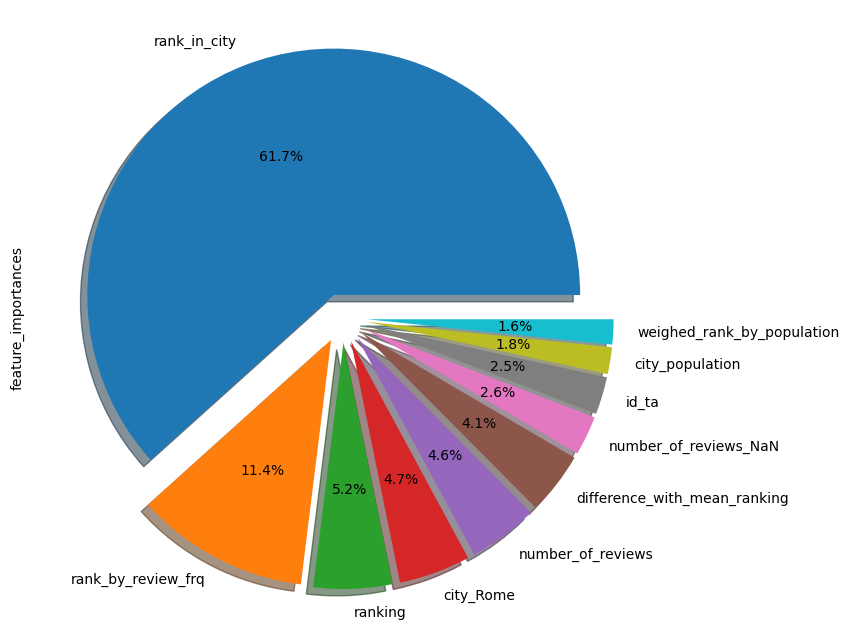

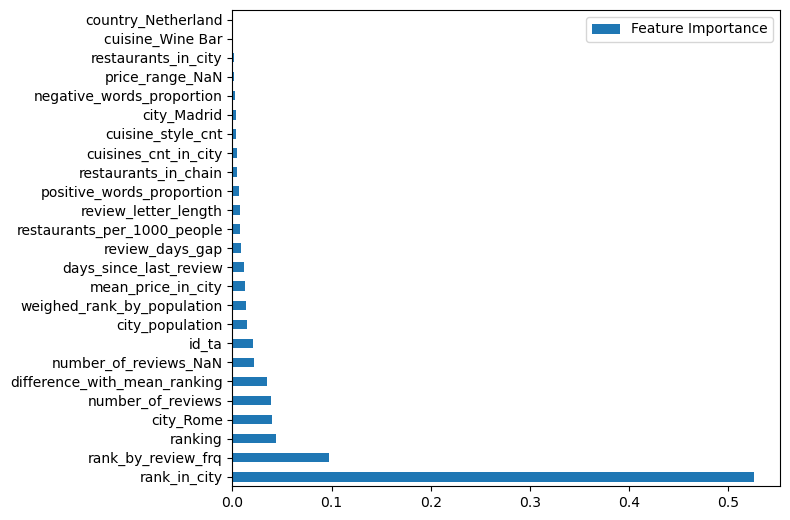

In [150]:
# Посмотрим на градацию признаков по их важности 
feature_importances = [round(x, 3) for x in rf_model.feature_importances_] 
feature_importances_df = pd.DataFrame({'features' : list(X.columns), 'feature_importances': feature_importances}) \
                          .sort_values(by = 'feature_importances', ascending = False)
display(feature_importances_df)

feature_importances_df[:10].plot.pie(
                        explode = [0.1] * 10,
                        labels = feature_importances_df.features,
                        y = 'feature_importances',
                        autopct = '%1.1f%%',
                        shadow = True,
                        legend = False,
                        figsize = (8, 8));

pd.DataFrame(feature_importances, index = X_train.columns, columns = ['Feature Importance']) \
                .sort_values('Feature Importance', ascending = False)[:25].plot(kind = 'barh', figsize = (8, 5.3))
plt.tight_layout()

# 8. Submission

In [152]:
# Предсказываем рейтинги на тестовом датасете 
X_submission = test_df[cols]
y_submission_pred = rating_round(rf_model.predict(X_submission))

# Датасет с предсказаниями
submission_df = pd.DataFrame()
submission_df['Restaurant_id'] = data[data['sample'] == 0].restaurant_id
submission_df['Rating'] = y_submission_pred
display(submission_df.head(10))
submission_df.shape

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,2.0
8,id_8,4.0
9,id_9,4.5


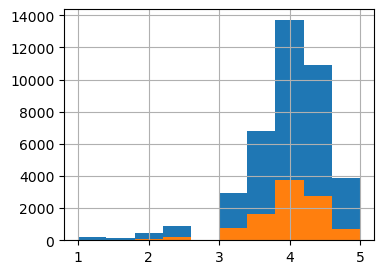

In [160]:
tr = train_df.rating.hist(figsize = (4, 3))
subm = submission_df.Rating.hist()
fig = tr.get_figure()
fig = subm.get_figure()

In [161]:
# Сохраняем предсказания
submission_df.to_csv('submission.csv', index = False)

In [ ]:
# submission_df = pd.read_csv('submission.csv')